Lane Following Problem
===========================

The dynamics model of an omnidirectional vehicle with no friction is defined by the following equation:

$$
\dot{p}^x(t) = (v_k + \dot{v}_k(t-T_s k))cos(\theta_k + \theta_k(t - T_sk))
$$
$$
\dot{p}^y(t) = (v_k + \dot{v}_k(t - T_s k))sin(\theta_k + \theta_k(t - T_s k))
$$

iLQR is applied to a vehicle in order to control them to follow a reference trajectory at a terminal velocity of $10 m/s$.

The state vector $\textbf{x}$ is defined as follows:
$$\begin{equation*}
\textbf{x} = \begin{bmatrix}
    p^x & p^y & v & \theta
    \end{bmatrix}^T
\end{equation*}$$

The action vector $\textbf{u}$ is defined as follows:
$$\begin{equation*}
\textbf{u} = \begin{bmatrix}
   \dot{v} & \delta
    \end{bmatrix}^T
\end{equation*}$$

**Note**: That since this dynamics model is nonlinear, this problem can be solved
more efficiently with a simple Linear Quadratic Regulator (LQR) instead. This
example is just used to demonstrate how to setup an auto-differentiated
dynamics model.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import sys
import os
sys.path.append(os.path.abspath('../'))
import random
import ilqr
import math

In [3]:
import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt


In [4]:
from ilqr import iLQR
from ilqr.cost import PathQRCost
from ilqr.examples.car import CarDynamics, CarCost

from bc import *
import pickle

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = xs[-1]
    final_control = us[-1]
    if iteration_count % 60 == 0:
        print("iteration", iteration_count, info, J_opt, final_state, final_control)


In [6]:
dt = 0.05
wheel_diameter = 1.0
dynamics = CarDynamics(dt, l=wheel_diameter)

An instantaneous cost function $l(\textbf{x}_t, \textbf{u}_t)$ is defined as follows:

$$
l(\textbf{x}_t, \textbf{u}_t) = \textbf{x}_t^T Q \textbf{x}_t + \textbf{u}_t^T R \textbf{u}_t
$$

where $Q$ is the state error and $R$ is the control error.

In order to approach the two vehicles to each other, $Q$ is set up to penalize differences in positions as $||\textbf{x}_0 - \textbf{x}_1||^2$ while penalizing non-zero velocities.

The following code generates the lane and boundaries. There are 150 way points along the reference trajectory. The boundary is +-3 vertically away from the reference trajecotry.S

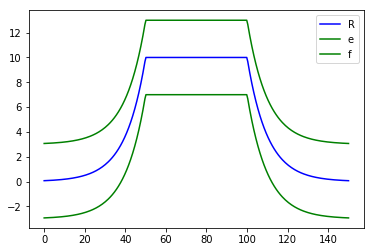

In [7]:
def lane(posx):
    ts = [50, 100, 150]
    rate = 10.0
    height = 10.0
    if posx <= ts[0]:
        return height * np.exp((posx - ts[0])/rate), np.arctan(height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1] and posx <= ts[2]:
        return height * np.exp((ts[1] - posx)/rate), np.arctan(- height * np.exp((ts[1] - posx)/rate))

def nominal(posx):
    ts = [50, 100, 150]
    rate = 10.0
    height = 10.0
    if posx <= ts[0]:
        return height * np.exp((posx - ts[0])/rate), np.arctan(height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1]:
        return height * np.exp((ts[1] - posx)/rate), np.arctan(- height * np.exp((ts[1] - posx)/rate))

def barrier_u(posx):
    return + 1 + posx, + 3 + lane(posx)[0], lane(posx)[1]
                                                                      
def barrier_l(posx):
    return - 1 + posx, - 3 + lane(posx)[0], lane(posx)[1]
    
posx_path = np.linspace(0, 150, 300)
x_path = [[posx_path[i], lane(posx_path[i])[0], 10, lane(posx_path[i])[1]] for i in range(300)]


posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend("Reference Path")

# Instantenous state cost.
Q = np.eye(dynamics.state_size)
Q[3, 3] = 0.0


R = np.eye(dynamics.action_size)
R[0, 0] = 1.0
R[1, 1] = 1.0

barriers = np.array([0, 1, 0, 0]) 

q = np.zeros((dynamics.state_size, 1))
r = np.zeros((dynamics.action_size, 1)) 
A = np.array([[[0, 1, 0, 0]], [[0, -1, 0, 0]]])
b = np.array([[3.0], [3.0]])
q1 = [1., 1.]
q2 = [0.1, 0.1]
#A = np.array([[[0, 1, 0, 0]]])
#b = np.array([11])

Now use iLQR to solve this trajectory following problem. Safety constraint is added such that the vehicle stay within the boundaries. The vehicles are initialized at $(0, 0)$ with velocities $10$. The look ahead horizon is 30.

In [8]:
N = len(x_path)
n = 30  # Number of time steps in trajectory.
J_hist = []
expert_traj = []

x0 = x_path[0]  # Initial state.
# Random initial action path.
#us_init = np.random.uniform(-1, 1, (n - 1, dynamics.action_size))
us_init = np.zeros((n - 1, dynamics.action_size))

for i in range(0, int(N - n) + 1):
    k = 3
    if i % k != 0:
        continue
        #pass
    x_path_ = x_path[i: i + n]
    cost = CarCost(Q = Q, q = q, R = R, r = r, A = A, b = b, q1 = q1, q2 = q2,\
                   x_nominal = x_path_,\
                   x_barrier_u = barrier_u,\
                   x_barrier_l = barrier_l)
    ilqr = iLQR(dynamics, cost, n - 1)
    xs, us = ilqr.fit(x0, us_init, on_iteration=on_iteration)

    x0 = xs[k][:]
    expert_traj = expert_traj + [[xs[i], us[i]] for i in range(k)]

iteration 0 accepted [2.86095619] [14.50765645  0.28179717 10.0079509   0.02046102] [-0.00055083 -0.00343113]
iteration 0 accepted [2.86883054] [16.01044343  0.32754796 10.00980505  0.02376484] [-0.00061831 -0.00400046]
iteration 0 accepted [2.87840518] [17.51327868  0.38072705 10.01158429  0.02766802] [-0.00068169 -0.00461776]
iteration 0 accepted [2.88998483] [19.01606555  0.4425365  10.01329065  0.03217587] [-0.00074131 -0.00535591]
iteration 0 accepted [2.90406731] [20.51868963  0.51437709 10.01493552  0.03739919] [-0.00079803 -0.00622563]
iteration 0 accepted [2.92140887] [22.02100609  0.59787484 10.01653668  0.04346835] [-0.00085302 -0.00723823]
iteration 0 accepted [2.94311062] [23.52282703  0.69491707 10.01811847  0.05052238] [-0.00090765 -0.0084157 ]
iteration 0 accepted [2.97073887] [25.02390689  0.80769398 10.01971421  0.05872231] [-0.0009637  -0.00978397]
iteration 0 accepted [3.00649858] [26.52392124  0.93874607 10.02136834  0.06825172] [-0.00102344 -0.01137569]
iteration 

/home/depend/workspace/MPSC_Guided_Imitation_Learning/ilqr/ilqr/controller.py:168: UserWarning: exceeded max regularization term
  warnings.warn("exceeded max regularization term")


iteration 0 accepted [57.73071995] [52.33319011  9.49486898 10.40643537  0.08811161] [-0.02106637  0.06832951]
iteration 0 accepted [64.35787174] [53.97266651  9.45074085 10.4263751   0.10207299] [-0.02134122  0.07597561]
iteration 0 accepted [69.43917619] [55.59566301  9.45326117 10.42322785  0.12382223] [-0.01990243  0.08099381]
iteration 0 accepted [73.00591481] [57.2013249   9.4641938  10.39891454  0.13577379] [-0.0169473   0.08796458]
iteration 0 accepted [76.00542499] [58.77692658  9.4745365  10.3634945   0.1407277 ] [-0.01326824  0.09419116]
iteration 0 accepted [79.60168611] [60.31810405  9.49610625 10.34311076  0.13713806] [-0.01093738  0.09379457]
iteration 0 accepted [78.22664246] [61.90821533  9.53642494 10.30830318  0.13471564] [-0.00790858  0.09498046]
iteration 0 accepted [70.05564208] [63.58251532  9.66850248 10.31199287  0.11272586] [-0.00850268  0.07823801]
iteration 0 accepted [60.30279446] [65.2324031   9.7765598  10.33204081  0.08064104] [-0.01056362  0.05419784]
i

TypeError: 'NoneType' object is not subscriptable

The result can be visulized by executing the following code.

In [9]:
X = []
Y = []
posx = []
posy = []
v = []
theta = []

for i in expert_traj:
    posx.append(i[0][0])
    posy.append(i[0][1])
    v.append(i[0][2])
    theta.append(i[0][3])



posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]

#pickle.dump((X, Y), open('expert_traj.p', 'wb'))

The red curve in this plot is the trajecotry of the MPC vehicle. 

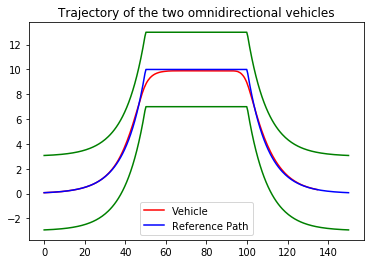

In [10]:

_ = plt.title("Trajectory of the two omnidirectional vehicles")
_ = plt.plot(posx, posy, "r")

_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend(["Vehicle", "Reference Path"])

In [ ]:
N = len(x_path)
H = 30  # Number of time steps in trajectory.
J_hist = []
expert_pts = []


num_pts = 50000
for pt in range(num_pts):
    x0 = [] # Initial state.
    i = random.randint(0, len(x_path) - H - 1)
    x0 = [x_path[i][0], \
          x_path[i][1] + 1.0 * (2 * random.random() - 1.0), \
          x_path[i][2] + 1.0 * (2 * random.random() - 1.0), \
          x_path[i][3] + 1.0 * (2 * random.random() - 1.0)]

    # Random initial action path.
    us_init = np.random.uniform(-1, 1, (H - 1, dynamics.action_size))
    #us_init = np.zeros((N, dynamics.action_size))
    print("Point %d" % pt)
    x_path_ = x_path[i: i + H]
    cost = CarCost(Q = Q, q = q, R = R, r = r, A = A, b = b, q1 = q1, q2 = q2,\
                   x_nominal = x_path_,\
                   x_barrier_u = barrier_u,\
                   x_barrier_l = barrier_l)
    ilqr = iLQR(dynamics, cost, H - 1)
    xs, us = ilqr.fit(x0, us_init, on_iteration=on_iteration)

    
    x_barrier_u = [i for i in x_path_[0:H]]
    for pos in x_barrier_u:
        pos[1] += 3.0
    x_barrier_l = [i for i in x_path_[0:H]]
    for pos in x_barrier_l:
        pos[1] -= 3.0
        
        
    x = [x0]
    for pos in range(H):
        if x_barrier_u[pos][1] - x_barrier_l[pos][1] != 6.0:
            exit()
        x.append(x_barrier_u[pos][:])
        x.append(x_barrier_l[pos][:])
    u = us[0]
    expert_pts = expert_pts + [[x, us[0]]]
    print(len(x))


Point 0
iteration 0 accepted [70.65638397] [58.1199412   9.67934095 10.45768316  0.13384053] [-0.0141628   0.08046326]
61
Point 1
iteration 0 accepted [51.9048074] [17.87264648  1.84135455  9.59200485 -0.154983  ] [ 0.01765729 -0.36380589]
61
Point 2
iteration 0 accepted [2293.06421878] [99.3119844  12.77512931 10.03449629  4.57657145] [ 0.00951006 -0.97242672]
61
Point 3
iteration 0 accepted [22.51169318] [135.15836929  -0.21195009  10.12811703  -0.64311294] [ 0.00379405 -0.14463844]
61
Point 4
iteration 0 accepted [12.98850955] [28.29310254  1.16951319 10.21439876  0.09250452] [ 0.00134601 -0.01828025]
61
Point 5
iteration 0 accepted [176.60767917] [ 1.07143457e+02  2.82317258e+00  1.04092763e+01 -1.00524775e-01] [-0.00206353  0.16561603]
61
Point 6
iteration 0 accepted [134.99508557] [23.8735427   2.04628846  9.64114194  0.72980507] [ 0.01804475 -0.39374978]
61
Point 7
iteration 0 accepted [58.2180675] [76.03059885  8.89811952  9.74828661  0.31940555] [0.00682768 0.20979601]
61
Poin

61
Point 66
iteration 0 accepted [27.13121973] [143.61243299  -0.52263259  10.32111604  -0.48207274] [-0.00197624 -0.15165025]
61
Point 67
iteration 0 accepted [839.5352727] [70.51335596 14.84385069  9.23181743 -0.08947603] [-0.29240337 -0.39827471]
61
Point 68
iteration 0 accepted [62.74462928] [20.12311713 -0.36020658 10.21805087  0.51822475] [0.00105714 0.22040416]
61
Point 69
iteration 0 accepted [28.65482098] [25.40846831  0.52418023 10.04959202  0.24709013] [0.00699588 0.18125914]
61
Point 70
iteration 0 accepted [21.25890786] [19.17087898  0.29407693 10.09822096  0.24271643] [0.00245178 0.10348483]
iteration 60 accepted [7.25957034] [19.55035812  0.46810462 10.12381326  0.04177987] [-0.00617169  0.        ]
61
Point 71
iteration 0 accepted [127.40748157] [90.66893278  9.93565183  9.72483229 -0.47913787] [0.00790429 0.19307749]
61
Point 72
iteration 0 accepted [2707.49465952] [103.24128248   9.27993746   8.8817709    4.47779147] [ 0.05987274 -1.06319853]
61
Point 73
iteration 0 a

61
Point 131
iteration 0 accepted [59.33596775] [32.04165827  0.9188422   9.60656015  0.27633664] [0.01057967 0.21771359]
61
Point 132
iteration 0 accepted [380.04631741] [119.27655951   0.42428309   9.39288933  -0.8451167 ] [0.02263954 0.15587167]
61
Point 133
iteration 0 accepted [1407.02140768] [115.40701849  11.90083684   9.28167824   1.19045384] [ 0.05117995 -0.43928366]
61
Point 134
iteration 0 accepted [130.91519315] [107.87526585   5.29479182   9.88941924  -0.24976594] [ 0.00358888 -0.16458243]
61
Point 135
iteration 0 accepted [1160.18534995] [28.0494986  -7.83741664  9.38458018 -1.64997672] [0.03245119 0.80332824]
61
Point 136
iteration 0 accepted [2260.74958683] [87.73810929  7.68862297  9.09155799 -5.68136537] [0.04669322 1.46936887]
61
Point 137
iteration 0 accepted [644.46032254] [44.51252965  0.16431548  9.66936352  0.85985916] [ 0.02584309 -0.03501869]
61
Point 138
iteration 0 accepted [145.77350398] [52.54526853  8.60521388  9.95935622  0.40882048] [-0.13760351  0.0709

61
Point 196
iteration 0 accepted [241.58728074] [67.49341247 13.18565872  9.77711554 -0.13128213] [ 0.01701613 -0.12996571]
61
Point 197
iteration 0 accepted [1964.48101865] [117.51532427   5.10449608   9.45413798   2.32030706] [ 0.03577254 -0.44798618]
61
Point 198
iteration 0 accepted [153.30649152] [70.0774     11.70799809  9.41718745 -0.34654849] [ 0.0241728  -0.08020829]
61
Point 199
iteration 0 accepted [259.99725148] [88.90603687  5.94134227  9.75443542  0.13003116] [0.01829506 0.24541234]
61
Point 200
iteration 0 accepted [1874.40721877] [92.61918353  2.63949982  9.19781116 -4.22910419] [0.02416391 1.24307232]
61
Point 201
iteration 0 accepted [3227.53260823] [99.13373159  9.27306534  8.73242843 -6.56051418] [0.07710987 1.80902419]
61
Point 202
iteration 0 accepted [1073.86249665] [69.68663506 19.44269302  9.67151008  1.4704595 ] [ 0.04242511 -0.60092039]
61
Point 203
iteration 0 accepted [38.13179756] [ 1.19514118e+02  1.36054187e+00  1.04807048e+01 -2.52660448e-02] [-0.00820

61
Point 260
iteration 0 accepted [37.12023815] [79.80436032  9.85178971 10.0709873  -0.14555704] [-0.00191647 -0.06739514]
61
Point 261
iteration 0 accepted [185.82291981] [30.6509732   1.71541812 10.03413205  0.33687207] [ 0.00370719 -0.01274456]
61
Point 262
iteration 0 accepted [38.22316178] [138.65265616   0.3564711   10.32293182  -0.17940086] [ 0.00020022 -0.15316407]
61
Point 263
iteration 0 accepted [47.79213941] [ 7.86539113e+01  9.57212688e+00  9.98052963e+00 -3.14491874e-02] [0.00327783 0.13377045]
61
Point 264
iteration 0 accepted [66.01259007] [82.89222761  9.82929339  9.83987252  0.12636523] [ 0.00195021 -0.12363718]
61
Point 265
iteration 0 accepted [19.88623486] [15.73225873  0.7257987  10.02254621  0.49941679] [0.00570093 0.1349365 ]
61
Point 266
iteration 0 accepted [3377.56469783] [28.33621446 -1.98296109  9.18127404 -3.46037459] [0.0219548  1.35813787]
61
Point 267
iteration 0 accepted [262.12304528] [94.77497961  5.37577506  9.41915947 -0.4634545 ] [0.02156145 0.57

61
Point 325
iteration 0 accepted [2863.06295797] [-1.49896067  0.8066075   9.03476629  4.7913392 ] [ 0.05442483 -1.20790474]
61
Point 326
iteration 0 accepted [147.31702328] [89.80470002 12.35640216  9.80607699 -0.33707222] [ 0.01329641 -0.12773976]
61
Point 327
iteration 0 accepted [58.54755024] [7.75729874e+01 9.88073780e+00 1.02636773e+01 6.55492139e-02] [-0.00628971  0.07201927]
61
Point 328
iteration 0 accepted [39.27059937] [ 8.20514318e+01  9.84249216e+00  1.00074949e+01 -6.52426521e-02] [ 0.00646557 -0.05028382]
61
Point 329
iteration 0 accepted [55.60821284] [65.38402601 10.53434802  9.8018456  -0.11492566] [-0.00139892 -0.08636031]
61
Point 330
iteration 0 accepted [146.45971831] [146.12735537  -0.51136372  10.30545844   0.35636908] [0.00271305 0.26233386]
61
Point 331
iteration 0 accepted [134.12268384] [64.81309179  7.65970369  9.50185554 -0.38008284] [0.0150221  0.49821014]
61
Point 332
iteration 0 accepted [53.98141428] [ 9.37154989e+01  9.74942436e+00  1.03180373e+01 -1

61
Point 390
iteration 0 accepted [55.25589608] [144.91393474   1.64619523   9.47304112  -0.20176636] [ 0.01935663 -0.29969774]
61
Point 391
iteration 0 accepted [55.68972944] [106.78224077   5.92668006  10.31319775  -0.44674292] [-0.00785363 -0.12149915]
61
Point 392
iteration 0 accepted [68.20043355] [8.02389735e+01 1.03161678e+01 1.03962629e+01 3.91769850e-02] [-0.0024713   0.01729274]
61
Point 393
iteration 0 accepted [67.97050956] [72.79701399  8.99470988  9.5443686   0.1367786 ] [0.01737388 0.22543994]
61
Point 394
iteration 0 accepted [4979.57343662] [99.66486046  6.2453393   9.46871162  3.11123916] [ 0.01762817 -1.47477883]
61
Point 395
iteration 0 accepted [18.56010048] [26.13414265  1.21238722 10.29676369  0.28673591] [-0.00348826  0.00061351]
61
Point 396
iteration 0 accepted [970.88859251] [ 7.52026995 -8.939007    9.68033209 -1.92986189] [0.05591633 1.06115181]
61
Point 397
iteration 0 accepted [84.10254921] [95.53832123  9.72480818  9.60959545  0.18936811] [ 0.00426159 -0

61
Point 454
iteration 0 accepted [9.73505603] [1.36436431e+02 3.06113443e-01 9.85055516e+00 4.70097080e-02] [0.00165232 0.07465254]
iteration 60 accepted [7.41841967] [ 1.36621318e+02  2.52636909e-01  9.93585611e+00 -2.96982685e-02] [3.62623102e-03 7.27222246e-65]
61
Point 455
iteration 0 accepted [195.37078949] [105.70622001   7.01844671   9.65561283  -0.54695365] [ 0.00229206 -0.02173522]
61
Point 456
iteration 0 accepted [93.04601443] [92.13532936  9.35552391 10.30638138  0.250371  ] [0.00638726 0.26596797]
61
Point 457
iteration 0 accepted [447.27945875] [23.03741006  7.39468543 10.2435424   0.88677015] [ 0.0149839  -0.35731734]
61
Point 458
iteration 0 accepted [68.08789607] [93.93350049  9.44560327 10.43954165 -0.49940101] [-0.00681034 -0.14046673]
61
Point 459
iteration 0 accepted [1330.07313917] [114.88389653  12.45047613   9.41981654   0.77202193] [ 0.05676999 -0.48366906]
61
Point 460
iteration 0 accepted [61.96470642] [8.11180258e+01 1.00356229e+01 1.04976358e+01 1.22386210

61
Point 516
iteration 0 accepted [38.38145684] [16.0969287   0.44371345 10.29195081  0.08134082] [-0.00043826 -0.0023424 ]
61
Point 517
iteration 0 accepted [228.55742315] [144.23786779  -2.24713648   9.77731985  -0.72894695] [ 0.02411723 -0.15743142]
61
Point 518
iteration 0 accepted [173.36437094] [133.10071037   2.34387877  10.0238376   -0.43625121] [ 0.00765301 -0.25232839]
61
Point 519
iteration 0 accepted [47.20036551] [126.27642457   0.88800883   9.71075394  -0.33198314] [ 0.00411915 -0.04488067]
61
Point 520
iteration 0 accepted [777.38918027] [80.98937221  6.89106173  9.85317579 -2.25188097] [0.01874714 0.83545527]
61
Point 521
iteration 0 accepted [991.79347227] [131.37893506  -1.46619694   9.36507726  -4.1013153 ] [ 0.02113907 -0.05415443]
61
Point 522
iteration 0 accepted [23.53154646] [34.19588422  2.08831929 10.25391826  0.14662229] [-0.00105728  0.03745761]
61
Point 523
iteration 0 accepted [3322.93393327] [7.06765012 3.15612179 9.49438876 1.56372502] [ 0.02769521 -0.68

61
Point 580
iteration 0 accepted [822.86278504] [34.61905758  8.09506147  9.94455476  1.97415043] [ 0.04075304 -0.66210308]
61
Point 581
iteration 0 accepted [96.53715866] [131.55019981   1.81562819   9.59613575  -0.41459519] [ 0.00795995 -0.08066478]
61
Point 582
iteration 0 accepted [1079.53831841] [34.86364008  5.79274597  9.4936853   3.44322333] [ 0.02116721 -1.2919787 ]
61
Point 583
iteration 0 accepted [21.64097628] [35.72488492  2.5293295  10.18945347  0.19219597] [-0.00342464 -0.03572649]
61
Point 584
iteration 0 accepted [152.34362288] [7.33591673e+01 1.19958495e+01 9.63592682e+00 1.42168564e-02] [ 0.02658072 -0.14566283]
61
Point 585
iteration 0 accepted [57.63180559] [115.26294474   3.62586672  10.23106792  -0.128241  ] [-1.05552091e-04 -2.70344736e-01]
61
Point 586
iteration 0 accepted [676.94014219] [27.47101253  8.90737787 10.33399687  0.65323471] [ 0.01140063 -0.62974665]
61
Point 587
iteration 0 accepted [111.50374479] [39.0298319   6.74097452  9.70533328  0.436679  ] 

61
Point 645
iteration 0 accepted [188.6726348] [98.72177672  6.06490267  9.7004069  -0.24359043] [0.02123213 0.37024095]
61
Point 646
iteration 0 accepted [33.01297128] [121.49291964   1.34587606  10.42091811   0.50576378] [-0.00772253  0.15595516]
61
Point 647
iteration 0 accepted [266.77902653] [137.57579725   2.21366503   9.28514044  -0.24005055] [ 0.04210575 -0.17553646]
61
Point 648
iteration 0 accepted [1257.45138523] [124.11619393   1.65587368  10.07956951   2.8152865 ] [ 0.01755724 -0.5676476 ]
61
Point 649
iteration 0 accepted [351.77071247] [9.63971074e+01 7.79933573e+00 9.53462372e+00 1.15220589e-02] [0.03643729 0.07223851]
61
Point 650
iteration 0 accepted [231.72107425] [1.11944673e+02 4.56052761e+00 9.98283123e+00 8.30273622e-03] [ 0.00231864 -0.19565859]
61
Point 651
iteration 0 accepted [27.40107743] [28.20343794  1.74804822  9.7401947  -0.05422286] [ 0.00653195 -0.01288211]
61
Point 652
iteration 0 accepted [380.86295891] [107.05620204   0.17783656  10.05229479  -0.72

61
Point 709
iteration 0 accepted [20.11975763] [25.76984873  1.30796759  9.82858655  0.07652964] [-0.00035361 -0.03062484]
61
Point 710
iteration 0 accepted [41.2597481] [ 6.22178539e+01  9.81333904e+00  9.93235416e+00 -2.21272705e-02] [ 0.00027719 -0.05267709]
61
Point 711
iteration 0 accepted [1525.00880771] [99.57883624 10.08784045  8.70848085 -4.83175048] [0.05852698 1.03672924]
61
Point 712
iteration 0 accepted [156.02915779] [108.45108428   3.9310761    9.91987178  -1.27420337] [-0.00137864  0.26634827]
61
Point 713
iteration 0 accepted [22.58066976] [29.15919069  0.86905171 10.36936125 -0.36078246] [-0.00462275 -0.07667918]
61
Point 714
iteration 0 accepted [491.77804058] [93.22516564 15.89394321 10.07477423  0.66004335] [ 0.01784562 -0.48111806]
61
Point 715
iteration 0 accepted [45.19032324] [133.27389685   0.43097883   9.66065889  -0.21343846] [0.00276405 0.01979718]
61
Point 716
iteration 0 accepted [479.12581598] [140.53285264  -5.1971028    9.85566002   0.23464913] [-0.00

61
Point 774
iteration 0 accepted [46.3556673] [103.86578268   6.07618273  10.13699368  -0.51718232] [-0.00151417  0.0077431 ]
61
Point 775
iteration 0 accepted [238.48684798] [122.150829     0.51961486  10.27566774  -1.26362686] [-0.15049747 -0.18959344]
61
Point 776
iteration 0 accepted [94.99594093] [101.44311329   6.43885458   9.59107933  -0.15257982] [0.01293908 0.28775948]
61
Point 777
iteration 0 accepted [277.88244035] [123.14079959   3.68063495   9.98011145  -0.25389983] [ 0.02062378 -0.03238063]
61
Point 778
iteration 0 accepted [271.95097295] [72.22612127  8.18907703 10.21381437 -1.81781246] [-0.29969541 -0.18898262]
61
Point 779
iteration 0 accepted [215.25467996] [86.08500527  6.13960316  9.31911449 -0.17795689] [0.01943877 0.25188802]
61
Point 780
iteration 0 accepted [138.98794737] [48.13776496  9.36764149  9.62403437  0.35963806] [ 0.00683912 -0.07156363]
61
Point 781
iteration 0 accepted [200.56186345] [117.13443442   3.04654212  10.25339272  -0.49158603] [-0.00549516 

61
Point 839
iteration 0 accepted [2703.7904062] [104.32327187  14.92394362   9.80060135   2.41410284] [ 0.01649468 -0.93548877]
61
Point 840
iteration 0 accepted [95.97161146] [98.6287782  10.33638427 10.20129875 -0.56166743] [ 0.00875827 -0.23881606]
61
Point 841
iteration 0 accepted [52.79757989] [89.78633386  9.93543767 10.03335899 -0.09786462] [ 0.00037795 -0.02493282]
61
Point 842
iteration 0 accepted [36.15455823] [1.45436015e+02 9.16081105e-03 1.01226968e+01 5.98688196e-02] [-0.00360762 -0.06337447]
61
Point 843
iteration 0 accepted [53.36022021] [ 7.94845621e+01  9.80783450e+00  9.78321704e+00 -1.68173785e-02] [0.00406276 0.03066936]
61
Point 844
iteration 0 accepted [2824.23754338] [53.48672251 14.37124906  9.40561755  4.65463225] [ 0.0469862  -1.30707669]
61
Point 845
iteration 0 accepted [300.17848082] [129.83840249   5.4420266    9.95399314   0.53361193] [ 0.00843325 -0.24724243]
61
Point 846
iteration 0 accepted [1583.1396264] [122.20657599   0.96707608   9.59417173   3.6

61
Point 903
iteration 0 accepted [338.35959065] [78.30161592 15.24107923  9.93264467  0.17918555] [ 0.02731193 -0.42821569]
61
Point 904
iteration 0 accepted [1307.95546972] [111.29181914   8.2192111    9.75358265   2.86230546] [ 0.00387332 -0.70692184]
61
Point 905
iteration 0 accepted [782.7067334] [10.38151952 -8.16899713  9.68541914 -2.16493823] [0.0215858  0.57983746]
61
Point 906
iteration 0 accepted [931.52386673] [54.76479902  2.67053361  9.28388328 -2.73982507] [0.04315866 0.9953189 ]
61
Point 907
iteration 0 accepted [1958.69480799] [123.73223041   2.53068152   9.67091179   4.73664979] [ 0.03303372 -1.69598488]
61
Point 908
iteration 0 accepted [33.71512859] [19.05841911  0.29874918  9.56705262  0.0912301 ] [ 0.0060524  -0.03024876]
61
Point 909
iteration 0 accepted [14.57892026] [18.44912837  0.73097556  9.861252   -0.15289305] [ 0.00818611 -0.08603134]
61
Point 910
iteration 0 accepted [26.01874731] [131.50531213   0.79750761  10.41005247   0.21773234] [-0.0058733   0.0433

61
Point 968
iteration 0 accepted [44.44505097] [15.05959007  0.72627593  9.60042467 -0.09821923] [ 0.01067986 -0.04985314]
61
Point 969
iteration 0 accepted [94.59918551] [92.1482532   7.94133296  9.64216533  0.25566918] [0.01834128 0.35803011]
61
Point 970
iteration 0 accepted [100.74020849] [104.10538334   4.1589316    9.85124234  -0.43629052] [0.01008136 0.34834226]
61
Point 971
iteration 0 accepted [1950.81265419] [114.53055239   4.34353244  10.59617885  -1.45694797] [-0.16719003  0.34323707]
61
Point 972
iteration 0 accepted [25.59790689] [132.67881723   0.97117957   9.72961441  -0.17633407] [ 0.00637153 -0.18318436]
61
Point 973
iteration 0 accepted [168.91011702] [92.27193287 12.21045121  9.44454795  0.42594563] [ 0.02629068 -0.33077632]
61
Point 974
iteration 0 accepted [1271.4986415] [28.41358084  3.08524891  9.73198082  2.35661121] [ 0.04390367 -0.63035716]
61
Point 975
iteration 0 accepted [3124.74458784] [126.60715918   1.06311631   8.80328366  -2.08087647] [ 0.07698095 -0

61
Point 1031
iteration 0 accepted [76.50443042] [9.65340434e+01 9.94016857e+00 1.03117457e+01 7.77547836e-03] [-0.00441695  0.0263336 ]
61
Point 1032
iteration 0 accepted [3635.36630388] [106.74613257   1.2994986    9.82392654   1.91001978] [ 0.01372869 -0.71481268]
61
Point 1033
iteration 0 accepted [94.33098949] [143.88889161   0.95619915   9.62716178   0.46458193] [ 0.01104851 -0.3667023 ]
61
Point 1034
iteration 0 accepted [42.3005167] [31.09702752  0.94084451  9.70893833  0.3746279 ] [0.00454308 0.01838346]
61
Point 1035
iteration 0 accepted [3865.7184167] [112.08344473   0.46688202   9.17511823  -0.16481097] [ 0.03249947 -0.63000719]
61
Point 1036
iteration 0 accepted [20.54052814] [147.35663924  -0.49117063   9.82125906   0.32744988] [0.0058729  0.08469809]
61
Point 1037
iteration 0 accepted [1465.594142] [118.85503427  -0.40971114   9.87253952  -7.88869569] [0.02941767 0.6637153 ]
61
Point 1038
iteration 0 accepted [441.22550203] [60.96240347 11.38382157 10.40164604 -0.6522523

61
Point 1095
iteration 0 accepted [54.89127391] [103.49741603   6.97001081   9.9210504   -0.52633446] [-0.00765923 -0.02406845]
61
Point 1096
iteration 0 accepted [565.20773413] [28.53790531 -6.53026981  9.94660373 -0.72537727] [-0.01397102  0.71810027]
61
Point 1097
iteration 0 accepted [682.4455808] [98.06226904  3.31416862  9.60983305 -3.13058292] [0.03480897 0.96603184]
61
Point 1098
iteration 0 accepted [188.53937664] [19.9798025  -0.53952129  9.98198099  0.21270068] [0.02200865 0.19677044]
61
Point 1099
iteration 0 accepted [54.37130491] [110.42710666   3.23709812  10.33014441  -0.65124872] [-0.00566314 -0.00386052]
61
Point 1100
iteration 0 accepted [703.83534804] [7.88702833e+01 1.56597926e+01 1.00007568e+01 6.00417176e-02] [ 0.02730463 -0.4075295 ]
61
Point 1101
iteration 0 accepted [63.29799103] [9.64560153e+01 9.69741331e+00 1.00913870e+01 7.36378142e-02] [-0.00197166  0.04488383]
61
Point 1102
iteration 0 accepted [117.2237558] [ 7.85873152e+01  9.20178888e+00  9.60730619e

61
Point 1160
iteration 0 accepted [50.80269255] [8.03960251e+01 9.90089235e+00 1.02699373e+01 2.91380318e-02] [-0.00200046 -0.06151146]
61
Point 1161
iteration 0 accepted [61.45803535] [75.17748525 10.22894086 10.31843029  0.47899886] [-0.00040694  0.10762871]
61
Point 1162
iteration 0 accepted [21.66250133] [125.12407496   0.75062219  10.28477573  -0.43140166] [-0.00311364 -0.20347536]
61
Point 1163
iteration 0 accepted [68.55434919] [ 7.45388680e+01  1.02397135e+01  1.00786760e+01 -2.25761692e-02] [ 0.00671934 -0.03315467]
61
Point 1164
iteration 0 accepted [46.96596695] [29.64216692  1.02780461 10.24697074  0.23976422] [5.96570811e-05 1.55397877e-01]
61
Point 1165
iteration 0 accepted [1441.25610242] [76.18399788  7.18117003  9.00190635 -3.73584533] [0.02771528 1.03556678]
61
Point 1166
iteration 0 accepted [363.30017069] [ 1.04832076e+02  2.31969944e+00  9.70326746e+00 -9.01021548e-02] [0.0191316  0.15099639]
61
Point 1167
iteration 0 accepted [328.37910533] [9.06552800e+01 1.4265

61
Point 1225
iteration 0 accepted [1844.21342319] [23.79000931  3.6942529   9.06610539  1.73427031] [ 0.06087669 -1.02677207]
61
Point 1226
iteration 0 accepted [100.19242929] [101.5327909    6.12650331   9.56778127  -0.59012737] [0.03221197 0.31062187]
61
Point 1227
iteration 0 accepted [7.22789753] [21.23116228  0.59460865  9.91465218 -0.12393105] [ 0.00152558 -0.09191626]
61
Point 1228
iteration 0 accepted [14.73023607] [ 1.26139476e+02  7.11083715e-01  1.00755918e+01 -7.56713909e-02] [-0.00181607 -0.10965878]
61
Point 1229
iteration 0 accepted [842.28382182] [54.98689953 13.36802931 10.18522856  2.90146313] [ 0.01877473 -0.8142414 ]
61
Point 1230
iteration 0 accepted [53.16080287] [111.04797482   3.88015031  10.5237551   -0.41712985] [-0.01766873 -0.20495133]
61
Point 1231
iteration 0 accepted [744.12402829] [93.04221655  3.92034919  9.1928091  -2.58480008] [0.03849807 0.97965335]
61
Point 1232
iteration 0 accepted [47.70898724] [ 7.96634807e+01  9.89519627e+00  1.02084438e+01 -4.

61
Point 1287
iteration 0 accepted [396.2342918] [55.53560072 12.79866484  9.97066727  0.51682018] [ 0.01479155 -0.36351465]
61
Point 1288
iteration 0 accepted [30.72503457] [30.26479948  1.28604282 10.2749761  -0.29909496] [-0.00487651 -0.27676426]
61
Point 1289
iteration 0 accepted [38.44379058] [21.79567095 -0.38223911  9.85981649  0.26711545] [0.00596651 0.14602312]
61
Point 1290
iteration 0 accepted [4541.92360312] [ 5.31277673  0.42302792  9.08133508 -2.91896651] [0.03864525 0.02158323]
61
Point 1291
iteration 0 accepted [58.64376934] [111.46147373   2.43827749  10.52917823  -0.60278367] [-0.00885738  0.09691519]
61
Point 1292
iteration 0 accepted [305.0066463] [14.62320368 -0.95764539  9.57269336  0.14016941] [0.01114713 0.04242032]
61
Point 1293
iteration 0 accepted [695.14416209] [140.38408159   5.72391653   8.92895154   1.75285892] [ 0.06379308 -0.55163944]
61
Point 1294
iteration 0 accepted [62.36320388] [84.49777698  9.41050597 10.31963996 -0.74447003] [ 7.07552666e-05 -2.1

61
Point 1352
iteration 0 accepted [303.37383353] [15.95577347 -0.93442523 10.15327191  0.11064852] [0.0036388  0.10339493]
61
Point 1353
iteration 0 accepted [299.92069479] [108.08161636   0.51778772   9.65653484  -0.27088914] [0.03912785 0.12617383]
61
Point 1354
iteration 0 accepted [862.41543144] [120.45054321   3.58320459   9.93516811   1.49929138] [ 0.01676343 -0.46299639]
61
Point 1355
iteration 0 accepted [2569.822054] [16.03073764  5.02058311  9.4322938  -0.56412681] [ 0.0296774  -0.32217633]
61
Point 1356
iteration 0 accepted [452.5006607] [19.94817719  6.40152311  9.76493992  1.55025174] [ 0.00856122 -0.51521226]
61
Point 1357
iteration 0 accepted [658.9783519] [49.79549178  8.74720852  9.96496621 -1.8783413 ] [0.00442491 0.63020475]
61
Point 1358
iteration 0 accepted [1254.54697549] [84.77103664 10.09597614  9.53654013 -1.55977633] [0.02201571 0.72208018]
61
Point 1359
iteration 0 accepted [31.35353521] [ 1.22340792e+02  5.67892033e-01  9.89913719e+00 -9.76129440e-02] [0.00

61
Point 1416
iteration 0 accepted [56.47127166] [71.4611206  10.45020054  9.66967402 -0.12141199] [ 0.00574815 -0.16574044]
61
Point 1417
iteration 0 accepted [90.08985601] [83.73060938  8.4189502   9.81129439  0.16586292] [0.00884239 0.14315097]
61
Point 1418
iteration 0 accepted [2169.54542147] [126.15286171   6.89167077   9.37235144   0.86114886] [ 0.06581379 -0.77470801]
61
Point 1419
iteration 0 accepted [1981.10861671] [69.08301669 19.64530331 10.2140341   1.83745356] [ 0.02950189 -0.67364455]
61
Point 1420
iteration 0 accepted [2942.85435311] [ 3.59727987 -3.05090245  9.30491874 -6.10822474] [0.02269356 1.48029162]
61
Point 1421
iteration 0 accepted [65.16873938] [96.42083781  8.91026708  9.68932908  0.2134589 ] [0.00738009 0.23625538]
61
Point 1422
iteration 0 accepted [208.55948055] [113.33207677  -1.00989368   9.91200366  -0.86961896] [0.00122035 0.39006121]
61
Point 1423
iteration 0 accepted [56.23646629] [ 9.69527344e+01  9.55643045e+00  9.65045409e+00 -9.27886137e-02] [0.

61
Point 1479
iteration 0 accepted [70.02076621] [21.73041617  2.90189106  9.71051914 -0.0969752 ] [ 0.00462438 -0.26438553]
61
Point 1480
iteration 0 accepted [2262.95741523] [53.42459358  6.20046736  8.58725103  1.72584267] [0.03925738 0.19394841]
61
Point 1481
iteration 0 accepted [764.98883913] [128.0018228    8.30390517   9.41207036   1.16795434] [-0.03030366 -0.61114238]
iteration 60 accepted [19.14037341] [ 1.32313783e+02  3.91596373e-01  9.77312291e+00 -4.44792137e-02] [ 1.21293693e-02 -4.24139568e-32]
61
Point 1482
iteration 0 accepted [88.56186904] [61.72364409 10.47044216  9.48554804  0.30208183] [ 0.00686712 -0.10103491]
61
Point 1483
iteration 0 accepted [44.79288201] [19.96595117  0.4944115   9.62388456  0.23252098] [ 0.00775763 -0.06898095]
61
Point 1484
iteration 0 accepted [169.71852641] [57.86200103  8.43855268 10.1301025   0.45891719] [0.00682381 0.27069145]
61
Point 1485
iteration 0 accepted [49.71693342] [ 9.73060628e+01  9.80321506e+00  9.83300013e+00 -4.80346545e

61
Point 1542
iteration 0 accepted [1211.12050403] [32.15116544 10.17793223  9.57897221  2.49582086] [ 0.03840834 -0.46955627]
61
Point 1543
iteration 0 accepted [284.010847] [62.53097512  8.82636159  9.85179097 -1.2796588 ] [0.00916132 0.62101906]
61
Point 1544
iteration 0 accepted [739.18361597] [91.52141992 17.63857944  9.51792821  1.11946249] [ 0.04335079 -0.45062393]
61
Point 1545
iteration 0 accepted [72.5168475] [106.44095336   6.02285302  10.33285847  -0.57060946] [-0.00833414 -0.09592783]
61
Point 1546
iteration 0 accepted [52.4131465] [69.40730284 10.43265544 10.30057554  0.30640913] [-0.00280161  0.10967952]
61
Point 1547
iteration 0 accepted [2261.62221228] [104.53980925   2.89676146   9.81838125   3.12430015] [ 0.02434078 -0.4617237 ]
61
Point 1548
iteration 0 accepted [234.69208942] [6.07247715e+01 1.26645014e+01 9.65919734e+00 1.78312145e-02] [ 0.01905046 -0.26338774]
61
Point 1549
iteration 0 accepted [58.56726889] [ 1.40052186e+02  8.14951120e-01  9.51499651e+00 -1.332

61
Point 1605
iteration 0 accepted [57.84833788] [ 1.44886591e+02 -7.30864336e-01  9.48462207e+00  5.47075705e-02] [0.01187176 0.05438182]
61
Point 1606
iteration 0 accepted [2693.51912874] [50.55155301  9.45112799  9.55281587  5.94765186] [ 0.04978101 -1.61940633]
61
Point 1607
iteration 0 accepted [32.57250079] [33.34070789  2.26214995  9.70830471  0.34771498] [ 0.00473689 -0.14370463]
61
Point 1608
iteration 0 accepted [80.32895146] [44.70873977  7.24957041  9.62603234  0.3299961 ] [ 0.01911564 -0.17683124]
61
Point 1609
iteration 0 accepted [58.91242307] [ 7.99785770e+01  1.00908741e+01  9.68170708e+00 -1.10061849e-02] [0.00337904 0.04605567]
61
Point 1610
iteration 0 accepted [3022.80083769] [6.31023255 5.15334169 9.83204869 5.38451427] [ 0.04209803 -1.62764591]
61
Point 1611
iteration 0 accepted [80.66524461] [57.36913337  9.25564215 10.01103427 -0.47331825] [0.00030137 0.18385894]
61
Point 1612
iteration 0 accepted [807.55768211] [130.54666582  -3.40057456   9.84774424  -2.06127

61
Point 1670
iteration 0 accepted [1047.93921103] [125.10259925  -0.26798249   8.97733887   3.3104253 ] [ 0.03503852 -0.58573967]
61
Point 1671
iteration 0 accepted [177.4054011] [57.27071097 10.07846569 10.00647182  0.43135317] [-0.0095035  -0.05029784]
61
Point 1672
iteration 0 accepted [4763.77394398] [100.6690391   10.21197074   8.66724658   0.14203264] [ 0.07788624 -0.37705118]
61
Point 1673
iteration 0 accepted [108.72240954] [ 9.69541076e+01  9.91202683e+00  1.02511069e+01 -7.46575119e-02] [-0.00360676  0.10580119]
61
Point 1674
iteration 0 accepted [51.42879092] [93.83410695  9.87570504  9.97525567 -0.23197197] [ 0.00672746 -0.12894586]
61
Point 1675
iteration 0 accepted [61.31350805] [ 1.29337901e+02 -3.56520601e-01  9.86260220e+00  5.03832308e-02] [0.01352659 0.1975882 ]
61
Point 1676
iteration 0 accepted [115.10267587] [47.67967344  8.02299805  9.80376706  0.62393094] [-0.00218892 -0.03026958]
61
Point 1677
iteration 0 accepted [46.30473631] [9.21785595e+01 9.92964716e+00 9

61
Point 1734
iteration 0 accepted [66.43914698] [91.60222771 10.2531385  10.38515747  0.65589265] [-0.0025002  0.2306206]
61
Point 1735
iteration 0 accepted [9.23730269] [28.60197366  1.39861689  9.8401365   0.04470456] [ 0.00929227 -0.18672274]
61
Point 1736
iteration 0 accepted [3044.82289174] [126.3219925    3.12392994   9.18592607  -1.0283957 ] [ 0.0259643 -0.5081994]
61
Point 1737
iteration 0 accepted [174.67049342] [ 9.22517474e+01  1.03664535e+01  9.93563352e+00 -4.96084114e-02] [ 0.00214945 -0.03982956]
61
Point 1738
iteration 0 accepted [101.11498702] [34.4353292   0.88422647  9.9421079   0.39182848] [0.0196498  0.18585415]
61
Point 1739
iteration 0 accepted [109.00948204] [97.66521514 10.33799229  9.56910898 -0.11048295] [ 0.01041317 -0.05043733]
61
Point 1740
iteration 0 accepted [218.29091601] [145.27153302  -4.33547513   9.73071856  -0.22619419] [0.02899587 0.28070413]
61
Point 1741
iteration 0 accepted [163.09059416] [50.68364767 10.17661148 10.18221399  1.00107027] [-0.

61
Point 1798
iteration 0 accepted [53.96566172] [101.16159017   9.03798155  10.21664743  -0.49079207] [-0.00113661 -0.08715573]
61
Point 1799
iteration 0 accepted [60.01158937] [91.58533582 10.40021163  9.88045618 -0.57860935] [ 0.01465173 -0.15534701]
61
Point 1800
iteration 0 accepted [62.28482904] [71.16854689  9.41531046 10.19993964  0.17758591] [-0.0026265   0.13265051]
61
Point 1801
iteration 0 accepted [2977.60230774] [1.02133872e+02 9.71399442e+00 9.12113001e+00 5.99869551e-03] [ 0.02283951 -0.45352394]
61
Point 1802
iteration 0 accepted [165.20121456] [62.25067642 10.79994284 10.20006082 -0.14780981] [ 0.0002097  -0.11042605]
61
Point 1803
iteration 0 accepted [3266.79009704] [107.03810014   9.65703152  10.08149395   3.65212029] [ 0.01821173 -0.76669418]
61
Point 1804
iteration 0 accepted [252.13042418] [48.20246332 10.65772602 10.01846141  1.21992623] [ 0.00353712 -0.48494208]
61
Point 1805
iteration 0 accepted [127.54671067] [46.24425884  4.10712867 10.31550717  0.58672265]

iteration 0 accepted [47.40849962] [ 1.40386963e+02  3.75174702e-01  9.93582706e+00 -6.62133348e-02] [ 0.0063145  -0.08507729]
61
Point 1862
iteration 0 accepted [804.58198194] [ 1.62086632e+01  7.66159560e+00  9.24190809e+00 -4.20025227e-03] [ 0.04911923 -0.18615662]
61
Point 1863
iteration 0 accepted [180.98650222] [107.17159209   1.55325998   9.89812263  -0.29111377] [0.0166172  0.20340102]
61
Point 1864
iteration 0 accepted [885.90606475] [84.305748    5.85742023  9.99242002 -2.35034784] [0.01528099 0.91393571]
61
Point 1865
iteration 0 accepted [62.97570199] [65.1238079  10.33638956  9.9787868  -0.49247451] [ 0.01205724 -0.27654407]
61
Point 1866
iteration 0 accepted [540.77885799] [61.19869698 17.41020706  9.71197289  1.39453728] [ 0.03681694 -0.78309143]
61
Point 1867
iteration 0 accepted [118.40691024] [75.5356301   9.22788581  9.51319578  0.31915737] [0.00985263 0.01766766]
61
Point 1868
iteration 0 accepted [269.5388048] [43.0682208   8.15869383  9.82983446  0.45646197] [ 0.0

61
Point 1925
iteration 0 accepted [67.50953446] [34.34836022  3.56187788  9.4996268   0.32901411] [ 0.00601715 -0.09959356]
61
Point 1926
iteration 0 accepted [628.46541217] [134.1804871    6.12619052   9.50567029   0.55992027] [ 0.02732904 -0.51589193]
61
Point 1927
iteration 0 accepted [10.62391991] [ 1.48497295e+02 -2.30505783e-02  9.87989341e+00  6.88945371e-02] [5.49469708e-05 3.72144305e-02]
61
Point 1928
iteration 0 accepted [1850.84061644] [106.10127128   9.16133392   9.27747675   2.25649663] [ 0.05072183 -0.78956649]
61
Point 1929
iteration 0 accepted [23.81425115] [1.38457743e+02 7.73760674e-02 9.87363536e+00 1.42465009e-01] [0.00250604 0.10975793]
61
Point 1930
iteration 0 accepted [450.4504839] [16.63405922  7.3234106   9.38430406  1.50182721] [ 0.01822042 -0.72390299]
61
Point 1931
iteration 0 accepted [9.72647789] [1.23966719e+02 8.67800229e-01 1.00438678e+01 2.38797788e-02] [-0.00707122  0.04166995]
61
Point 1932
iteration 0 accepted [1771.2353156] [106.6365706    5.701

61
Point 1989
iteration 0 accepted [56.78771267] [ 8.66884211e+01  9.71060165e+00  9.94580902e+00 -2.61727181e-03] [ 0.00779452 -0.03485717]
61
Point 1990
iteration 0 accepted [49.33556433] [69.62019881  9.4836271   9.96060347  0.6495685 ] [0.00371017 0.28545908]
61
Point 1991
iteration 0 accepted [1609.93458424] [39.7554318   5.25014006 10.20011353  1.0127428 ] [0.01130686 0.03348121]
61
Point 1992
iteration 0 accepted [2966.58746781] [98.88163103  8.01386528  9.27937324  1.64194381] [ 0.01717143 -1.21224614]
61
Point 1993
iteration 0 accepted [49.78219075] [19.90977072  0.1639363  10.09169136  0.44895254] [0.01642809 0.34337832]
61
Point 1994
iteration 0 accepted [1032.07615221] [33.03803499  5.18433391  9.14779508  3.12236463] [ 0.05682755 -0.97858823]
61
Point 1995
iteration 0 accepted [52.93093218] [97.72688003  9.37651486  9.98973327  0.20072187] [0.00591435 0.23782199]
61
Point 1996
iteration 0 accepted [145.06702543] [109.25627426   4.03681825  10.17447076  -0.13181306] [-0.001

61
Point 2052
iteration 0 accepted [634.62671977] [139.46249563   6.04634464   9.50317357   0.82969207] [ 0.05015295 -0.40725405]
61
Point 2053
iteration 0 accepted [24.95996151] [1.19821808e+02 1.42298611e+00 1.03522907e+01 3.62859016e-02] [-0.00393012  0.09973868]
61
Point 2054
iteration 0 accepted [24.51134751] [147.25829627   0.18066427  10.36352614   0.3538071 ] [-0.00295988  0.2042597 ]
iteration 60 accepted [21.09888864] [ 1.47373887e+02  1.01484345e-01  1.03774108e+01 -7.19414864e-03] [-0.01934308  0.        ]
61
Point 2055
iteration 0 accepted [1738.91719709] [128.27920616  10.63662845   9.88927111   1.61424135] [ 0.02077988 -0.77669268]
61
Point 2056
iteration 0 accepted [2160.10318958] [ 0.36791656 -2.61279008 10.08753385 -1.08534717] [5.60201499e-04 1.03616677e+00]
61
Point 2057
iteration 0 accepted [43.94872772] [108.04879036   4.85676399  10.36728775  -0.46702016] [-0.00980918 -0.24675444]
61
Point 2058
iteration 0 accepted [1932.07406179] [112.27254659   6.72445713  10.1

61
Point 2115
iteration 0 accepted [645.96504088] [114.96473729   4.41842215   9.38331107  -1.31324581] [0.01957549 0.28738728]
61
Point 2116
iteration 0 accepted [73.82925786] [27.18438926 -0.07752383  9.5677661   0.16533631] [0.01134534 0.21731332]
61
Point 2117
iteration 0 accepted [283.62895381] [21.4680405   0.93544384  9.61810334  0.84009053] [-0.2522585  -0.25874373]
61
Point 2118
iteration 0 accepted [284.15828336] [45.98335314 11.48294974 10.18429582  0.71663003] [ 0.00961862 -0.27228518]
61
Point 2119
iteration 0 accepted [255.43223272] [54.35736151  6.46814596 10.09271384  0.13534277] [0.01835478 0.51863566]
61
Point 2120
iteration 0 accepted [338.27748453] [35.52720519  6.92323401 10.26884606 -0.15712275] [ 0.00518677 -0.66605791]
61
Point 2121
iteration 0 accepted [193.00500912] [43.11848756  8.42297117  9.34807259  0.61040048] [ 0.02526228 -0.09605766]
61
Point 2122
iteration 0 accepted [75.89643486] [27.66867054 -0.58480235  9.88678547  0.10787422] [0.00437105 0.08200019

61
Point 2177
iteration 0 accepted [177.93792444] [146.28466062  -1.92362814  10.30427685   0.21446656] [0.00571307 0.29422847]
61
Point 2178
iteration 0 accepted [78.65177574] [ 1.38924667e+02  1.28856835e+00  9.65462430e+00 -1.32926921e-01] [ 0.02397345 -0.11843172]
61
Point 2179
iteration 0 accepted [1030.24620463] [101.0404262   -1.31232223   9.91510077  -1.80901529] [0.02804352 0.79929194]
iteration 60 failed 41.68553011234805 [107.63081323   4.62935648  10.40091018  -0.48295957] [-0.01801349 -0.00130331]
61
Point 2180
iteration 0 accepted [66.83621098] [82.43857445  9.98476092 10.43684451  0.17088828] [-0.0079187  -0.07091048]
61
Point 2181
iteration 0 accepted [3268.6587289] [112.82786763  -2.94371435   9.76262727   5.9735291 ] [ 0.0179788  -1.55487924]
61
Point 2182
iteration 0 accepted [690.67298545] [109.49503292   8.21735466  10.0844056    0.61711494] [-0.0018715 -0.4300389]
61
Point 2183
iteration 0 accepted [3446.36277631] [35.89393105  3.82226727  8.70966644 -1.80240986] 

61
Point 2239
iteration 0 accepted [86.50709167] [17.24453645 -0.96024553  9.63304393  0.08285516] [0.01184567 0.09368539]
61
Point 2240
iteration 0 accepted [50.78270778] [ 8.60897962e+01  9.97920764e+00  9.77256328e+00 -3.52229473e-02] [-0.00445757 -0.03973716]
61
Point 2241
iteration 0 accepted [148.64171643] [131.54767382  -0.93653567   9.74356272  -0.23491532] [0.00553346 0.11073035]
61
Point 2242
iteration 0 accepted [245.68274254] [24.48710778 -3.7087724   9.52628983 -0.31428663] [0.02533668 0.37668216]
61
Point 2243
iteration 0 accepted [188.66211754] [41.43413901  7.3765167   9.78339695  0.19533422] [ 0.02599173 -0.33385062]
61
Point 2244
iteration 0 accepted [4867.99468928] [104.49258545  12.32421403   9.82819269  -2.9727903 ] [ 0.01843357 -0.33209264]
61
Point 2245
iteration 0 accepted [506.45020208] [50.9973723   5.71358732  9.89678062 -0.34555038] [0.03197048 0.19821144]
61
Point 2246
iteration 0 accepted [146.64256417] [ 8.52896208e+01  1.18338957e+01  9.86329236e+00 -2.3

61
Point 2303
iteration 0 accepted [54.52778845] [92.15815576 10.4818794   9.79949305 -0.19513683] [ 0.00512116 -0.10628522]
61
Point 2304
iteration 0 accepted [4530.74735108] [123.68991315  -2.50377291   9.98458515   5.52017874] [ 0.01927633 -1.31034363]
61
Point 2305
iteration 0 accepted [916.92732846] [102.93962365   9.1954132    9.07407564  -1.99395122] [0.03764569 0.33782752]
61
Point 2306
iteration 0 accepted [1568.10288179] [130.34495769  -2.21076438   8.24034827   0.42233144] [ 0.07241179 -0.49919185]
61
Point 2307
iteration 0 accepted [100.62054415] [19.16983336  3.09688046  9.65688025 -0.07234548] [ 0.02382551 -0.32263686]
61
Point 2308
iteration 0 accepted [10.58934453] [22.30152231  0.49613793  9.98389401  0.17297717] [-0.00053721  0.10335114]
61
Point 2309
iteration 0 accepted [20.75663727] [143.17076766  -0.31600209   9.70987432   0.20527023] [0.0050868 0.0458742]
61
Point 2310
iteration 0 accepted [38.60857792] [103.00080782   7.20067253  10.086328    -0.63817983] [-0.00

61
Point 2368
iteration 0 accepted [1650.53299252] [84.8531588   4.22492944  9.58691191 -4.11589279] [-0.06997267  0.99870657]
61
Point 2369
iteration 0 accepted [103.75947287] [124.57779855   0.1799892    9.48505201  -0.58637522] [0.00907195 0.12532962]
61
Point 2370
iteration 0 accepted [62.28744886] [21.27844231  0.64801185  9.82044015  0.25954773] [0.00327423 0.06000461]
61
Point 2371
iteration 0 accepted [826.15621136] [103.50361245   7.27877209   9.81649252   2.08296881] [ 0.00829032 -0.83898855]
61
Point 2372
iteration 0 accepted [227.39044102] [85.2991011   6.00728449  9.6014331  -0.2158067 ] [0.01790166 0.5084871 ]
61
Point 2373
iteration 0 accepted [30.35905894] [ 1.44035782e+02 -5.18821069e-01  9.82449999e+00  1.31887441e-01] [0.00445446 0.17547559]
61
Point 2374
iteration 0 accepted [271.80628243] [57.45377317 10.53676065  9.73772778 -0.78105818] [0.00870172 0.14762815]
61
Point 2375
iteration 0 accepted [234.47224807] [142.26418686   3.69761459   9.48018976   0.4022619 ] [

61
Point 2432
iteration 0 accepted [109.09409681] [1.03582007e+02 7.24818291e+00 9.65064584e+00 8.41509181e-02] [ 0.00229247 -0.29327492]
61
Point 2433
iteration 0 accepted [147.41539318] [111.65782355   3.31020682  10.42717947  -1.00023448] [-0.01534741  0.10708371]
61
Point 2434
iteration 0 accepted [3186.92886537] [86.02355649 13.44820623  9.84578505  3.46074652] [ 1.37595317e-04 -9.50220180e-01]
61
Point 2435
iteration 0 accepted [156.23867997] [41.32526751  4.53366427  9.48213818 -0.32869031] [0.00938788 0.11290366]
61
Point 2436
iteration 0 accepted [1464.69810399] [61.81063989  3.40064588  9.13433731 -1.67595948] [0.05012997 0.57528153]
61
Point 2437
iteration 0 accepted [2249.68809404] [116.90777345  -1.18940926   9.16872127   5.70503326] [ 0.02868266 -1.47634935]
61
Point 2438
iteration 0 accepted [245.95020912] [21.777093    2.01316179  9.97292632  1.3679949 ] [0.28974462 0.30845364]
61
Point 2439
iteration 0 accepted [675.21360693] [57.19735438  5.71700994  9.94545314 -0.123

61
Point 2496
iteration 0 accepted [2085.86840073] [46.4143769   0.46699858  9.95132262 -3.25151164] [0.01148702 1.4491489 ]
61
Point 2497
iteration 0 accepted [37.07979111] [13.76920449  0.07893376  9.94091611  0.12740706] [0.00773632 0.0198982 ]
61
Point 2498
iteration 0 accepted [1282.51616464] [36.61835113 12.7447427  10.06562011  2.13759   ] [ 0.02646569 -0.86720065]
iteration 60 accepted [15.87301863] [46.52502743  7.00692541 10.27945702  0.56075597] [-0.01300751  0.        ]
61
Point 2499
iteration 0 accepted [41.45183957] [ 1.43658687e+02  1.53877542e-01  1.03882885e+01 -7.56380946e-02] [-0.00246896 -0.004273  ]
61
Point 2500
iteration 0 accepted [102.91339042] [45.3771735   6.48314926 10.05180475  1.33930231] [-0.00267432 -0.246362  ]
61
Point 2501
iteration 0 accepted [127.15664205] [97.41668098  9.88668743  9.56251257  0.14577452] [ 0.01123141 -0.05617952]
61
Point 2502
iteration 0 accepted [47.44251228] [ 1.48016384e+02 -2.06728252e-02  1.04576151e+01 -2.92768911e-01] [-0.0

61
Point 2560
iteration 0 accepted [1199.89799624] [111.92738235   7.52185523   9.40402113   2.85029609] [ 0.044582   -1.06783792]
61
Point 2561
iteration 0 accepted [18.66028971] [140.80309693   0.18615642  10.20454653  -0.30503791] [-0.00091821 -0.08819589]
61
Point 2562
iteration 0 accepted [2083.01258877] [1.20808803e+02 4.22491958e+00 1.02866337e+01 5.71462916e-02] [-0.20871799 -0.38630548]
61
Point 2563
iteration 0 accepted [67.48480112] [95.82559193  9.37211928  9.67931901  0.11271701] [0.00381473 0.04450239]
61
Point 2564
iteration 0 accepted [38.70942213] [33.48184781  1.84987218  9.57340174 -0.13107413] [0.00642281 0.05377044]
61
Point 2565
iteration 0 accepted [597.89910843] [89.97324637 16.70394534  9.37507545  1.08473128] [ 0.06465068 -0.31310879]
61
Point 2566
iteration 0 accepted [188.50379263] [6.05777758e+01 7.76890366e+00 9.39434887e+00 5.50648806e-02] [0.02793378 0.08922407]
61
Point 2567
iteration 0 accepted [2788.62016923] [83.45305736 11.40926492  9.5832703  -2.42

61
Point 2622
iteration 0 accepted [2101.9971858] [102.96444004  10.08200203   9.62639726   3.85751319] [ 0.03824042 -1.13011955]
61
Point 2623
iteration 0 accepted [2632.85129187] [34.31634056 -3.29875087  9.32400233 -3.19506639] [0.0414291  0.84108841]
61
Point 2624
iteration 0 accepted [145.57678614] [98.11009625 11.7614918   9.83664597 -0.13615346] [ 0.01135591 -0.10802582]
61
Point 2625
iteration 0 accepted [2726.93252781] [96.07702217  6.14976886  9.62406595 -4.35562998] [0.03243793 1.24810002]
61
Point 2626
iteration 0 accepted [56.47161759] [101.15314747   9.13194821  10.2598658   -0.14776581] [-0.01008541  0.2657051 ]
61
Point 2627
iteration 0 accepted [255.91451008] [6.08817699e+01 8.97775494e+00 9.93752429e+00 1.35712468e-02] [0.00911551 0.04985772]
61
Point 2628
iteration 0 accepted [697.95382262] [102.46068482   3.3622207    9.69195403  -3.22530692] [0.00818861 0.8050404 ]
61
Point 2629
iteration 0 accepted [423.22052595] [50.4676434  14.12669248  9.57004031  1.48031103] [

61
Point 2686
iteration 0 accepted [124.61672661] [107.39916773   5.13013161  10.06707562  -0.34695421] [0.00448995 0.00566648]
61
Point 2687
iteration 0 accepted [73.90800198] [79.4860091  10.32842927  9.78013236 -0.33233967] [ 0.01498524 -0.23169414]
61
Point 2688
iteration 0 accepted [10.26161348] [138.69610404   0.27592816   9.97083321  -0.14168454] [ 0.00111939 -0.12630579]
61
Point 2689
iteration 0 accepted [149.88599031] [ 1.27282043e+02  2.24089430e+00  9.43224106e+00 -1.12572463e-01] [ 0.03283484 -0.23671517]
61
Point 2690
iteration 0 accepted [543.50301657] [95.09098183 15.93058334  9.40399751  1.0165281 ] [ 0.04341637 -0.31130989]
61
Point 2691
iteration 0 accepted [2145.69007406] [54.43620227  5.50551575  8.86947969 -4.32905598] [0.03401971 0.71100091]
61
Point 2692
iteration 0 accepted [50.57204442] [ 6.74114052e+01  9.68422899e+00  1.00755522e+01 -1.96937516e-02] [-0.00281615  0.00644343]
61
Point 2693
iteration 0 accepted [687.74737831] [121.422388     8.50653171   9.249

61
Point 2750
iteration 0 accepted [919.30994498] [129.71138946   5.96942817   9.59053982   3.13137284] [ 0.02538552 -0.49726303]
61
Point 2751
iteration 0 accepted [76.74824983] [ 5.94216493e+01  1.00113438e+01  1.03696294e+01 -5.35710398e-04] [-0.0063408  -0.08855066]
61
Point 2752
iteration 0 accepted [134.64297129] [21.6507297   3.3260117   9.98240961 -0.14466309] [ 0.01224623 -0.34993316]
61
Point 2753
iteration 0 accepted [80.39415623] [45.63448268  7.77263897 10.0430196   0.35279952] [ 0.0074627  -0.16452433]
61
Point 2754
iteration 0 accepted [68.16779794] [40.61564968  4.05585617 10.25231372  0.30563539] [-0.00397897 -0.01510658]
61
Point 2755
iteration 0 accepted [39.33670862] [64.07344985  9.65263885 10.03337299 -0.15969536] [ 0.00740924 -0.06229676]
61
Point 2756
iteration 0 accepted [792.37049869] [28.80195992  9.36134525 10.10078741  0.70089632] [ 0.02040785 -0.52753304]
61
Point 2757
iteration 0 accepted [94.05615877] [63.8630037  11.31014676  9.68750566 -0.44866047] [ 0

61
Point 2814
iteration 0 accepted [15.42584588] [28.86721405  0.96909616 10.05610529 -0.26849751] [ 0.00385071 -0.12431756]
61
Point 2815
iteration 0 accepted [296.93833019] [117.31182922   0.23081006   9.34640401  -1.27351704] [-0.2579281  -0.41539155]
61
Point 2816
iteration 0 accepted [95.40254331] [42.04119239  4.92602996 10.17151769  0.36056869] [ 0.01042907 -0.19953376]
61
Point 2817
iteration 0 accepted [50.69830954] [104.38395051   5.89416945  10.3877405   -0.60449515] [-0.00446389  0.11433141]
61
Point 2818
iteration 0 accepted [268.84316766] [118.41756846   4.06995457  10.3773739    1.41769717] [0.29363106 0.44203407]
61
Point 2819
iteration 0 accepted [43.45314511] [41.66228679  5.08280887  9.72855291  0.24218791] [ 0.00423838 -0.03392008]
61
Point 2820
iteration 0 accepted [27.72782261] [41.1413711   4.03517064 10.45022726  0.25479592] [-0.01272698 -0.06745913]
61
Point 2821
iteration 0 accepted [65.43445139] [13.98585464  0.57022331  9.5433894   0.03265472] [ 0.01218574 -

61
Point 2879
iteration 0 accepted [3726.36950238] [104.9855466    6.07724573   9.72044982  -1.03439923] [ 0.02030847 -0.4031404 ]
61
Point 2880
iteration 0 accepted [3488.77459652] [40.58831633 13.9418048  10.31230337  2.7727047 ] [ 0.03611122 -0.2500399 ]
61
Point 2881
iteration 0 accepted [661.33000849] [135.90599697   5.3704526    9.7071344    1.37302486] [ 0.01898638 -0.62363673]
61
Point 2882
iteration 0 accepted [2508.99474084] [123.18606542  -1.54025214   9.59169458   2.68629774] [ 0.02979904 -1.00004569]
61
Point 2883
iteration 0 accepted [41.8402098] [ 8.77145665e+01  9.90223506e+00  1.01126245e+01 -7.14502029e-03] [-0.00181071 -0.02721415]
61
Point 2884
iteration 0 accepted [6.0601914] [141.76026921   0.25229684  10.02881856  -0.21931141] [ 0.00290767 -0.18042722]
61
Point 2885
iteration 0 accepted [3511.79328821] [121.98528924   2.13235654   8.227646    -0.88845969] [ 0.04228297 -0.53700714]
61
Point 2886
iteration 0 accepted [1732.87106565] [121.57326378   4.91392324   9.1

61
Point 2944
iteration 0 accepted [17.2045964] [135.16148284   0.31837307  10.08816325   0.17675104] [0.01055958 0.14814525]
61
Point 2945
iteration 0 accepted [473.43576265] [16.3986549  -2.85355026  9.91202681 -0.58543994] [0.02665853 0.32740299]
61
Point 2946
iteration 0 accepted [497.90410092] [50.03108317 13.52717062 10.25099388 -0.14331492] [ 0.00540499 -0.00093467]
61
Point 2947
iteration 0 accepted [1570.25161277] [ 8.27939974 -8.02371052 10.18038928  0.14063909] [-0.02272114  0.70661267]
61
Point 2948
iteration 0 accepted [48.33248239] [69.33211572  9.9107412  10.08072044  0.5350572 ] [0.00875762 0.2755872 ]
61
Point 2949
iteration 0 accepted [1116.91948295] [68.09897157  6.28884203 10.35253727 -2.39951514] [0.00513022 0.8394808 ]
61
Point 2950
iteration 0 accepted [84.34726334] [73.42987263  9.92981025  9.53120893  0.15472719] [ 0.00789863 -0.10614617]
61
Point 2951
iteration 0 accepted [171.46017407] [87.59141755  8.78299984  9.77637631  0.41008913] [ 0.00922563 -0.11397692

61
Point 3008
iteration 0 accepted [236.64451408] [127.16072919   2.5829696   10.01802997  -0.35575397] [ 0.01343823 -0.1025143 ]
61
Point 3009
iteration 0 accepted [135.68709693] [39.90035263  5.62445597 10.14149509  0.08822583] [ 0.01043099 -0.35838391]
61
Point 3010
iteration 0 accepted [762.81265638] [47.8569339  13.02084905  9.77395429  0.40925163] [ 0.02815659 -0.23223381]
61
Point 3011
iteration 0 accepted [376.99362112] [33.84828515 -2.13519747  9.69121548 -0.37616946] [0.01510047 0.61486072]
61
Point 3012
iteration 0 accepted [5.28525784] [1.49402036e+02 1.14907263e-01 1.00496121e+01 7.56956714e-02] [ 0.00210526 -0.04401046]
61
Point 3013
iteration 0 accepted [1245.22651733] [128.90256935   5.49499137   9.33312912   2.95499137] [ 0.06115825 -0.90476876]
61
Point 3014
iteration 0 accepted [39.63326785] [25.1584283   0.71363944 10.42727619  0.02744334] [-0.00739298  0.01444841]
61
Point 3015
iteration 0 accepted [2149.02962918] [12.63106063  5.61001209  9.82113799  0.66910883] [

61
Point 3071
iteration 0 accepted [2216.71721709] [87.03627797 12.95617983  9.054553    4.89946928] [ 0.04063435 -1.50722009]
61
Point 3072
iteration 0 accepted [1923.21868439] [134.42664747   5.92168378   9.46811068   3.83242845] [ 0.036878   -1.11813982]
61
Point 3073
iteration 0 accepted [1507.53955687] [109.15754769   4.12894959   9.79061466  -1.43320614] [0.01236797 0.14544301]
61
Point 3074
iteration 0 accepted [2073.17977996] [125.9758574    0.31890567   9.33499933   5.23173061] [ 0.04025061 -1.45700644]
61
Point 3075
iteration 0 accepted [42.27255166] [70.27575558  9.67172942  9.81624962  0.15793348] [0.00466287 0.06604605]
61
Point 3076
iteration 0 accepted [63.71450521] [105.44873957   5.11887219   9.97902357  -0.38856002] [0.00414947 0.01344615]
61
Point 3077
iteration 0 accepted [53.57481475] [ 9.40148177e+01  1.00538659e+01  1.02207524e+01 -4.87664730e-02] [-0.00296951 -0.02094934]
61
Point 3078
iteration 0 accepted [3703.87474338] [118.51690598  -0.16632037   9.55169377 

61
Point 3135
iteration 0 accepted [139.32574834] [12.88508938 -0.94746265  9.49080999  0.50703692] [0.01800099 0.06997599]
61
Point 3136
iteration 0 accepted [65.39756499] [87.38113132 10.42995537  9.63931434 -0.19962544] [ 0.01412591 -0.05375482]
61
Point 3137
iteration 0 accepted [223.1256435] [118.70243412   3.60632256   9.6084793   -0.34279887] [ 0.01152831 -0.04311306]
61
Point 3138
iteration 0 accepted [33.375045] [41.83552393  4.84539995  9.68968182  0.15126012] [0.00224717 0.06209117]
61
Point 3139
iteration 0 accepted [61.45117958] [ 1.33115394e+02  1.22068892e+00  9.67443443e+00 -6.07321819e-02] [ 0.00952276 -0.08928888]
61
Point 3140
iteration 0 accepted [108.82087932] [72.44141615  8.70378597  9.58620579 -0.14074387] [0.01175355 0.07327392]
61
Point 3141
iteration 0 accepted [41.21586394] [39.25524556  3.58117424  9.70585914  0.50131402] [ 0.00751906 -0.04581932]
61
Point 3142
iteration 0 accepted [31.6541224] [ 1.37535229e+02  2.02287927e-01  9.93888096e+00 -6.77641179e-0

61
Point 3200
iteration 0 accepted [31.55670809] [40.88738392  4.03322729 10.43007671  0.43650476] [-0.00606179 -0.00054347]
61
Point 3201
iteration 0 accepted [928.42352015] [110.41102541  -3.58268078  10.44147924   0.82462407] [-0.00433756 -0.22184892]
61
Point 3202
iteration 0 accepted [260.17128176] [43.35552698  2.18987689  9.43394391 -0.18303299] [-0.21806346 -0.03427499]
iteration 60 accepted [35.91793449] [44.8290119   5.99674658  9.93248611  0.48545463] [ 5.27438077e-03 -1.31626939e-17]
61
Point 3203
iteration 0 accepted [71.09371403] [79.35577763  9.83463971 10.32216019 -0.54504512] [ 0.00250588 -0.18551536]
61
Point 3204
iteration 0 accepted [28.21449407] [18.97139747  0.66657044 10.01777163  0.94453068] [0.00775585 0.32122861]
61
Point 3205
iteration 0 accepted [120.78099605] [110.71016613   4.50870568  10.13253003  -0.29581587] [ 0.16356017 -0.38820016]
61
Point 3206
iteration 0 accepted [44.39952087] [1.52534079e+01 7.86553501e-01 9.65687024e+00 8.66856332e-04] [0.0063643

61
Point 3264
iteration 0 accepted [891.65845506] [84.1919243   5.00051005 10.0742406  -1.78485525] [0.01854165 0.67662752]
61
Point 3265
iteration 0 accepted [141.86753711] [6.08656109e+01 9.40569910e+00 1.02898421e+01 5.76527763e-02] [0.00085558 0.03632144]
61
Point 3266
iteration 0 accepted [1070.7907177] [17.65151746 -2.63466716  9.24664908 -3.66761467] [0.05017404 1.12162836]
61
Point 3267
iteration 0 accepted [2263.03235873] [86.56325598 14.31410852  9.61950837  4.82348804] [ 0.00370039 -1.18289685]
61
Point 3268
iteration 0 accepted [4300.13735343] [93.64735009  6.59972767  9.12866964 -3.07011909] [0.04962699 1.16839844]
61
Point 3269
iteration 0 accepted [55.49015721] [107.21052075   4.47877382  10.20356349  -0.70386034] [-0.00427735  0.06475709]
61
Point 3270
iteration 0 accepted [1830.83781711] [33.49171628 10.41921158  9.3670898   3.46143786] [ 0.00665922 -0.91301   ]
61
Point 3271
iteration 0 accepted [467.95730208] [14.92110836  7.316562    9.66540111  1.11577081] [ 0.0197

61
Point 3328
iteration 0 accepted [2996.16583055] [32.42969166 -1.88983243  9.24769863 -4.95233791] [0.10430816 0.95253441]
61
Point 3329
iteration 0 accepted [436.18409396] [58.9070134   9.0281449   9.92246425  0.51973614] [ 0.01498735 -0.18695697]
61
Point 3330
iteration 0 accepted [87.84204138] [134.1010649    0.86040563  10.17555921  -0.13550582] [ 0.00586613 -0.0379659 ]
61
Point 3331
iteration 0 accepted [162.93798135] [137.97492283  -1.51611886   9.8587141    0.28030784] [0.01393378 0.21879016]
61
Point 3332
iteration 0 accepted [2633.84469526] [ 1.21927860e+02 -6.31226369e-02  9.57496428e+00  4.11704750e+00] [ 0.04982323 -1.31570187]
61
Point 3333
iteration 0 accepted [207.44274522] [30.44690235 -1.71472108  9.44495575 -0.19325734] [0.04403518 0.15631705]
61
Point 3334
iteration 0 accepted [141.09954893] [53.79158946 12.54953181 10.39292184  0.3700002 ] [-0.00115494 -0.29328457]
61
Point 3335
iteration 0 accepted [3695.996829] [70.82032808  8.53387279  9.09371186 -5.85173973] 

61
Point 3391
iteration 0 accepted [54.08421496] [6.73660516e+01 1.02104222e+01 9.72068028e+00 2.74982003e-02] [ 0.00893863 -0.0740103 ]
61
Point 3392
iteration 0 accepted [3108.78405323] [ 3.88868605 -4.41087297 10.18094033 -2.64014189] [9.21360427e-04 1.02711608e+00]
61
Point 3393
iteration 0 accepted [98.11582888] [36.21955592  5.57009014  9.50631155  0.47421632] [ 0.01614864 -0.24035106]
61
Point 3394
iteration 0 accepted [53.69978184] [74.70617432  9.90552108 10.26410935  0.28856707] [-0.00109761  0.16053501]
61
Point 3395
iteration 0 accepted [734.89685263] [93.94717498  5.14453023  9.04547063 -2.98225883] [0.06526983 0.48328852]
61
Point 3396
iteration 0 accepted [268.46805661] [142.79838058   2.67050749  10.25877932  -0.30134995] [ 0.00768766 -0.25624421]
61
Point 3397
iteration 0 accepted [1434.29198068] [16.3023919   8.16335708  9.12839247  2.39576467] [ 0.06432707 -0.84274004]
61
Point 3398
iteration 0 accepted [183.78816696] [38.68855533  7.10148472  9.57252433  0.51476252]

61
Point 3455
iteration 0 accepted [460.10639637] [86.13490857  6.11209364  9.98214694  0.18569818] [0.00863672 0.2398884 ]
61
Point 3456
iteration 0 accepted [132.18205519] [49.20961345  9.93015209  9.95728785  0.09688874] [-0.00236042  0.0288633 ]
61
Point 3457
iteration 0 accepted [63.95097746] [85.48113153 10.29534392  9.68501192 -0.14700051] [ 0.01122866 -0.09006259]
61
Point 3458
iteration 0 accepted [78.07373715] [118.44413358   0.59206998   9.71457016  -0.26222862] [0.00171109 0.19148274]
61
Point 3459
iteration 0 accepted [1279.06041226] [91.25111063 19.40978228  9.89522387  1.5834154 ] [ 0.0339268  -0.66844698]
61
Point 3460
iteration 0 accepted [836.62504901] [86.44989094 13.40386531  9.16509015  2.65856408] [ 0.04099539 -0.60252851]
61
Point 3461
iteration 0 accepted [302.78067399] [32.13230539  5.05751909  9.59216565  0.3690981 ] [ 0.02282383 -0.26310784]
61
Point 3462
iteration 0 accepted [1029.7406139] [59.70246368  3.18705084  9.49832045 -2.62267007] [0.00740238 0.78280

61
Point 3520
iteration 0 accepted [698.34037953] [85.42932822  2.57826997  9.60797347 -0.28142988] [-0.04739     0.99303048]
61
Point 3521
iteration 0 accepted [2261.77981325] [70.65902592 17.7373878   9.96383903  4.28424707] [ 0.00365626 -1.36953672]
61
Point 3522
iteration 0 accepted [150.72545258] [41.95095675  5.41557585 10.30025911  0.24558047] [-0.00029514 -0.15452085]
61
Point 3523
iteration 0 accepted [2212.90208036] [133.67259226   7.05790159   9.97926147   2.1933048 ] [-0.00646116 -0.90842693]
61
Point 3524
iteration 0 accepted [799.98833316] [97.85105202 15.91985175 10.24372405 -0.2116037 ] [ 0.05853895 -0.14991947]
61
Point 3525
iteration 0 accepted [59.40544423] [101.15880141   8.59201294  10.08888033  -0.23441674] [0.00668702 0.1416408 ]
61
Point 3526
iteration 0 accepted [63.12270811] [7.57992188e+01 1.06203294e+01 9.61317631e+00 6.76930806e-02] [ 0.00866025 -0.08052867]
61
Point 3527
iteration 0 accepted [52.03512598] [91.26587407  9.81890166 10.26843217  0.21954109] [

61
Point 3585
iteration 0 accepted [20.01106944] [28.3426477   1.60156781  9.83355432 -0.32714974] [ 0.00946423 -0.17112323]
61
Point 3586
iteration 0 accepted [197.91035736] [143.62439299   3.53407472   9.64971357   0.62814248] [ 0.01123793 -0.47598457]
61
Point 3587
iteration 0 accepted [6.67162801] [17.34918488  0.43770479 10.02512233 -0.2813194 ] [ 0.00027603 -0.09743407]
61
Point 3588
iteration 0 accepted [68.41159454] [79.19694948  9.66511657  9.586187    0.13981178] [0.00699889 0.01767969]
61
Point 3589
iteration 0 accepted [1465.61745036] [39.09728261 -3.21031227  9.51985917 -2.91399453] [0.01259237 0.63559741]
61
Point 3590
iteration 0 accepted [15.47512958] [ 1.49563034e+02  1.69997556e-01  1.02191633e+01 -1.17209739e-01] [ 0.00179067 -0.00056464]
61
Point 3591
iteration 0 accepted [2793.55723821] [120.51398497   5.99215898   9.51736224  -2.38610698] [ 0.0330072  -0.14408328]
61
Point 3592
iteration 0 accepted [252.00008296] [121.55128091   1.23076131   9.72815116  -0.4904993

61
Point 3648
iteration 0 accepted [426.69001635] [15.71253827  5.02249819  9.41810379  0.2690014 ] [ 0.02056131 -0.12869711]
61
Point 3649
iteration 0 accepted [335.46333733] [55.01481274  6.95521447 10.0127693   1.00930751] [ 0.00899064 -0.02132385]
61
Point 3650
iteration 0 accepted [1259.56813732] [106.32148059   6.66809447  10.21630804  -2.5255434 ] [0.00356394 0.55638844]
61
Point 3651
iteration 0 accepted [290.92386421] [105.48126172   8.73694281   9.82856832   0.72416209] [ 0.00234775 -0.38570268]
61
Point 3652
iteration 0 accepted [27.72492247] [38.56751562  4.17648727  9.85568391 -0.1139458 ] [ 0.00641922 -0.25935144]
61
Point 3653
iteration 0 accepted [374.77893804] [72.01712393  4.29663508  9.3844948  -0.90541329] [0.03244569 0.58616704]
61
Point 3654
iteration 0 accepted [22.22383951] [46.16675354  6.53769269 10.2881341   0.51367083] [-0.00235632  0.03799349]
61
Point 3655
iteration 0 accepted [3605.06140325] [58.45130404 12.58622015 10.01566761  1.3822119 ] [-0.05364073 -

61
Point 3711
iteration 0 accepted [109.01731505] [99.70012919 11.46178366  9.59389442 -0.18872647] [ 0.01395801 -0.24946034]
61
Point 3712
iteration 0 accepted [46.47643273] [13.34969389 -0.06094174  9.63792373 -0.06527859] [0.00900605 0.10546936]
61
Point 3713
iteration 0 accepted [25.75422535] [20.90443895  0.38442542 10.38794859  0.09034233] [-0.00479755  0.00777854]
61
Point 3714
iteration 0 accepted [1185.63677999] [131.06453926   7.22008055  10.00510971   1.37283105] [ 0.0171708  -1.03029856]
61
Point 3715
iteration 0 accepted [17.55144719] [38.80379714  3.29170913 10.10260529  0.61957813] [0.00872726 0.08170739]
61
Point 3716
iteration 0 accepted [128.6527727] [ 1.07022459e+02  3.93511662e+00  1.03046157e+01 -3.00569395e-02] [-0.00365416  0.04980153]
61
Point 3717
iteration 0 accepted [2900.04826577] [99.20980465 12.94159301  9.54063009 -7.08465372] [0.03742142 1.42909287]
61
Point 3718
iteration 0 accepted [29.93669179] [25.18322573  0.96133316 10.22899067  0.13744772] [-0.000

61
Point 3775
iteration 0 accepted [7.26832213] [ 1.38759163e+02  2.75693831e-01  1.00723591e+01 -6.95326279e-02] [-0.00265797 -0.06723252]
61
Point 3776
iteration 0 accepted [42.11067937] [101.41801117   8.69026436  10.02949967  -0.41865547] [0.00067051 0.01541472]
61
Point 3777
iteration 0 accepted [86.26808679] [24.52667255  0.83464942 10.17392767 -0.26515147] [ 0.00453883 -0.22962702]
61
Point 3778
iteration 0 accepted [32.11965161] [15.27368697  0.38133267 10.41890636  0.31299156] [-0.00114025  0.02172693]
61
Point 3779
iteration 0 accepted [64.55952036] [73.37373739  9.40055103 10.47436421 -0.48389975] [-0.01161148 -0.05032592]
61
Point 3780
iteration 0 accepted [66.85527685] [37.57581584  2.49708112  9.53552552  0.05512154] [0.00484586 0.00212382]
61
Point 3781
iteration 0 accepted [31.64462146] [138.87785788   0.3300561   10.02631101   0.61485052] [0.01110405 0.17571758]
61
Point 3782
iteration 0 accepted [62.08898126] [3.15687035e+01 1.53280228e+00 1.03368485e+01 7.68628875e-0

61
Point 3839
iteration 0 accepted [59.99955004] [101.06244215   8.7469921    9.76570566  -0.65479062] [0.00704392 0.10067185]
61
Point 3840
iteration 0 accepted [51.69598749] [91.4905276  10.14939217 10.22932885  0.36804428] [0.00117776 0.1311592 ]
61
Point 3841
iteration 0 accepted [93.53233859] [64.27504715 11.39462392  9.9234607  -0.30739761] [ 0.00555639 -0.28917513]
61
Point 3842
iteration 0 accepted [417.1379377] [107.72384005   4.67645402   9.75351138   0.16295488] [ 0.00812677 -0.12818258]
61
Point 3843
iteration 0 accepted [47.30357182] [68.56180038  9.78957018  9.85244892  0.17592097] [0.00403738 0.04450385]
61
Point 3844
iteration 0 accepted [367.96215858] [99.68260803  5.56032545  9.95782611  0.10713207] [0.01874675 0.24549659]
61
Point 3845
iteration 0 accepted [210.97747935] [51.34970076  9.65363203 10.06058514  1.44338951] [ 0.14540593 -0.16210447]
61
Point 3846
iteration 0 accepted [424.37632724] [ 6.41310346e+01  1.34167859e+01  9.49149929e+00 -3.16952607e-02] [ 0.024

61
Point 3904
iteration 0 accepted [2350.9351201] [42.70210078  5.24788522  9.17604589 -3.77569649] [0.05780906 1.33940896]
61
Point 3905
iteration 0 accepted [264.42165221] [115.58791248   2.99561281   9.76675659  -0.76768167] [0.00254754 0.09959771]
61
Point 3906
iteration 0 accepted [75.01342301] [110.16448848   2.84390653  10.51907936  -0.42237665] [-0.00607992  0.21325267]
61
Point 3907
iteration 0 accepted [1174.54331742] [100.49649134  18.00769878  10.33954724   1.52102042] [ 0.01155737 -0.86542747]
61
Point 3908
iteration 0 accepted [53.29969361] [ 9.95217805e+01  9.16934299e+00  9.67346844e+00 -4.75935877e-02] [0.00617295 0.2093376 ]
61
Point 3909
iteration 0 accepted [1918.87246824] [33.00561624 -7.25539932  9.16106556 -0.576388  ] [0.09195745 0.83951127]
61
Point 3910
iteration 0 accepted [854.03141784] [126.20493853   3.73266224  10.42662071  -0.42436395] [-0.00228187  0.01812155]
61
Point 3911
iteration 0 accepted [1870.07218413] [64.56142703  1.20562257  9.97212672 -3.371

61
Point 3968
iteration 0 accepted [2609.29611327] [122.64526408   4.87154534   9.25953954   4.22876506] [ 0.01312918 -1.46006096]
61
Point 3969
iteration 0 accepted [319.20319654] [69.20169104 10.85248812 10.18579657  0.96177206] [ 0.29730344 -0.11829587]
61
Point 3970
iteration 0 accepted [22.64972586] [14.83067807  0.47365176 10.36731385  0.34832048] [-0.0088278   0.09969043]
iteration 60 accepted [20.1616538] [14.92652752  0.28830382 10.3621956   0.0356536 ] [-0.01857573  0.        ]
61
Point 3971
iteration 0 accepted [140.65179942] [35.96229406 -0.15912993 10.14209467  0.14693651] [0.01370487 0.36160039]
61
Point 3972
iteration 0 accepted [725.82561212] [121.66937824   3.23998532   9.88025863  -0.14427501] [-0.00068517 -0.06639276]
61
Point 3973
iteration 0 accepted [2356.89969981] [56.36282789 15.58899184 10.33846344  5.01417889] [-0.06704131 -1.50505266]
61
Point 3974
iteration 0 accepted [62.99357995] [136.74225131  -0.97710564   9.62199383   0.18020579] [0.01278908 0.0442094 ]

In [1]:


print("State Template: \n{}".format(expert_pts[0][0]))
print("Number of State Variables: {}".format(len(expert_pts[0][0])))
print("Number of States: {}".format(len(expert_pts)))


X = []
Y = []
n = 10

for i in range(len(expert_pts) - 1):
    X.append(expert_pts[i][0][0][:])
    for j in range(n):
        for k in expert_pts[i][0][j * 2]:
            X[-1].append(k)
        for k in expert_pts[i][0][j * 2 + 1]:
            X[-1].append(k)
    Y.append(np.exp(-np.logaddexp(0, -expert_pts[i][1][:])))
print("State Template: \n{}".format(X[0]))
print("Number of State Variables: {}".format(len(X[0])))
print("Number of States: {}".format(len(X)))

print("Control Template: \n{}".format(Y[0]))
print("Number of Controls: {}".format(len(Y)))
print("First Way Point: {}".format(x_path[0]))

NameError: name 'expert_pts' is not defined

In [31]:
pickle.dump((X, Y), open('expert_traj/expert_pts_16045_H10_bar.p', 'wb'))

Now train a simple regression model to output control given the current coordinate.

In [51]:
n = 30
agent = NeuralNetwork(input_size = (2 * n + 1) * 4, model_name = 'mlp_H30_bar_', batch_size = 500)#, checkpoint = 'checkpoints/mlp_H30_965.pt')

#agent.data_process(paths = ['expert_traj/expert_pts_10058_H30.p', 'expert_traj/expert_pts_15547_H30.p'])
agent.data_process(paths = ['expert_traj/expert_pts_16045_H30_bar.p'])

agent.train(num_epoch = 1000)


16045
[Epoch 1] avg_loss: 0.174
[Epoch 6] avg_loss: 0.133
[Epoch 11] avg_loss: 0.133
[Epoch 16] avg_loss: 0.132
[Epoch 21] avg_loss: 0.131
[Epoch 26] avg_loss: 0.129
[Epoch 31] avg_loss: 0.124
[Epoch 36] avg_loss: 0.121
[Epoch 41] avg_loss: 0.112
[Epoch 46] avg_loss: 0.027
[Epoch 51] avg_loss: 0.026
[Epoch 56] avg_loss: 0.026
[Epoch 61] avg_loss: 0.026
[Epoch 66] avg_loss: 0.026
[Epoch 71] avg_loss: 0.026
[Epoch 76] avg_loss: 0.026
[Epoch 81] avg_loss: 0.025
[Epoch 86] avg_loss: 0.025
[Epoch 91] avg_loss: 0.025
[Epoch 96] avg_loss: 0.026
[Epoch 101] avg_loss: 0.025
[Epoch 106] avg_loss: 0.025
[Epoch 111] avg_loss: 0.025
[Epoch 116] avg_loss: 0.025
[Epoch 121] avg_loss: 0.025
[Epoch 126] avg_loss: 0.025
[Epoch 131] avg_loss: 0.024
[Epoch 136] avg_loss: 0.024
[Epoch 141] avg_loss: 0.024
[Epoch 146] avg_loss: 0.025
[Epoch 151] avg_loss: 0.024
[Epoch 156] avg_loss: 0.024
[Epoch 161] avg_loss: 0.024
[Epoch 166] avg_loss: 0.024
[Epoch 171] avg_loss: 0.024
[Epoch 176] avg_loss: 0.024
[Epoch 1

In [53]:
def agent_run(agent, x0s):
    agent_traj = []
    for x0 in x0s:
        agent_traj.append([])
        for _ in range(0, N):
            i = abs(int(x0[0]/0.5))
            x_nn = []
            if i >= N - H - 1:
                break
            x_path_ = x_path[i: i + H]
            x_nn = x0[:]
            for j in x_path_[:]:
                for k in range(len(j)):
                    if k != 1:
                        x_nn.append(j[k])
                    else:
                        x_nn.append(j[k] + 3.0)
                for k in range(len(j)):
                    if k != 1:
                        x_nn.append(j[k])
                    else:
                        x_nn.append(j[k] - 3.0)
                        
            u = agent.run([x_nn])
            agent_traj[-1] = agent_traj[-1] + [[x0[:], u[0]]]
            x1 = dynamics.f(x0, u[0], i)[0]        
            x0 = x1[:].tolist()
    return agent_traj

x0s = []
batch_size = 20
for i_batch in range(batch_size):
    x0s.append([x_path[0][0] + 1.0 * (2 * random.random() - 1.0), \
          x_path[0][1] + 1.0 * (2 * random.random() - 1.0), \
          x_path[0][2] + 1.0 * (2 * random.random() - 1.0), \
          x_path[0][3] + 1.0 * (2 * random.random() - 1.0)])  # Initial state.
    
N = 300
H = 30
agent_traj = agent_run(agent, x0s)
        

print("Done")

Done


The red curve in the plot shows the trajectory of the regression model controller.

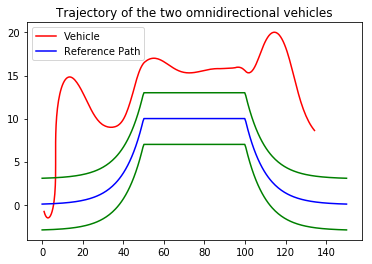

In [54]:
x_path = [[posx_path[i], lane(posx_path[i])[0], 10, lane(posx_path[i])[1]] for i in range(300)]
posx = []
posy = []
v = []
theta = []
for i in agent_traj[-1]:
    posx.append(i[0][0])
    posy.append(i[0][1])
    v.append(i[0][2])
    theta.append(i[0][3])
    
posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]

_ = plt.title("Trajectory of the two omnidirectional vehicles")
_ = plt.plot(posx, posy, "r")
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend(["Vehicle", "Reference Path"])

Now implement the MPSC guided controller. MPSC solves feasiblity problem to verify the safety of each output of the regression model. Once the output is unsafe, then MPC solves an optimal control and overrides the regression model.

In [30]:
N = len(x_path)
H = 30  # Number of time steps in trajectory.
n = 30
n_init = 0
#n_end = 250
n_end = N - H - 1
x0 = x_path[n_init]  # Initial state.
# Random initial action path.
us_init = np.zeros((n - 1, dynamics.action_size))

J_hist = []
nn_traj = []
mpc_traj= []
traj = []

for i in range(n_init, n_end):
    print(">>>>>Step {} at {}".format(i, x0))
    x_path_ = x_path[i: i + H]
    x_nn = []
    for j in [x0] + x_path_[0 : n]:
        for k in j:
            x_nn.append(k)
    u = agent.run([x_nn])
    #print("NN outputs control")
    agent_traj = agent_traj + [[x0, u[0, :]]]
    x0_ = dynamics.f(x0, u[0], i)
    #print("Get next state")

    if i <= N - H - 1:
        n_ilqr =  H 
    else:
        n_ilqr = N - i - 1
    x_path_ilqr = x_path[i + 1: i + 1 + n_ilqr]
    #us_init = np.random.uniform(-1, 1, (n_ilqr - 1, dynamics.action_size))
    
    cost_ = CarCost(Q = Q, q = q, \
                   R = R, r = r, \
                   A = A, b = b, \
                   q1 = q1, q2 = q2, \
                   x_path = x_path_ilqr, \
                   x_nominal = nominal)
    ilqr_ = iLQR(dynamics, cost_, n_ilqr - 1)
    xs, us = ilqr_.fit(x0_, us_init, on_iteration=on_iteration)
    #print("MPC verifying")
    
    
    if (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[0].T) - b[0,0]\
                   <= 0)).all() == True and \
        (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[1].T) - b[1,0]\
                  <= 0)).all() == True:
        traj.append([x0, u[0, :]])
        nn_traj.append(traj[-1])
        print("Utilize NN output {}".format(u))
    else:
        max_itr = 5
        while (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[0].T) - b[0,0]\
                   <= 0)).any() == False or \
        (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[1].T) - b[1,0]\
                  <= 0)).any() == False :
            if max_itr == 0:
                break
            max_itr -= 1    
            cost = CarCost(Q = Q, q = q, \
                   R = R, r = r, \
                   A = A, b = b, \
                   q1 = q1, q2 = q2, \
                   x_path = x_path_, \
                   x_nominal = nominal)
            ilqr = iLQR(dynamics, cost, H)
            xs, us = ilqr.fit(x0, us_init, on_iteration=on_iteration)
        traj.append([x0, us[0]])
        mpc_traj.append(traj[-1])
        x0_ = dynamics.f(x0, us[0], i)
        print("Utilize MPC output {}".format(us[0]))
    x0 = x0_[0][:]

>>>>>Step 0 at [0.0, 0.067379469990854673, 10, 0.0067378450344227981]
iteration 0 accepted [ 0.02924184] [ 15.01840062   0.29547169  10.01244889   0.02122318] [-0.00053378 -0.003778  ]
Utilize NN output [[ 0.29570881 -0.00121071]]
>>>>>Step 1 at [  5.00347868e-01   7.07507874e-02   1.00143690e+01   6.13249154e-03]
iteration 0 accepted [ 0.03548132] [ 15.52904789   0.31069569  10.01650701   0.02011403] [-0.00049516 -0.00554806]


/usr/lib/python3/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/lib/python3/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/depend/workspace/MPSC_Guided_Imitation_Learning/ilqr/ilqr/controller.py:168: UserWarning: exceeded max regularization term
  warnings.warn("exceeded max regularization term")


Utilize NN output [[ 0.28492764 -0.016281  ]]
>>>>>Step 2 at [  1.00140372e+00   7.38235467e-02   1.00282420e+01  -2.01898785e-03]
iteration 0 accepted [ 0.05168279] [ 16.04009404   0.32661342  10.02042863   0.02016344] [-0.00045044 -0.00654326]
Utilize NN output [[ 0.28186983 -0.0077549 ]]
>>>>>Step 3 at [  1.50315809e+00   7.28105094e-02   1.00419738e+01  -5.90730898e-03]
iteration 0 accepted [ 0.07787809] [ 16.55177314   0.34339504  10.02433999   0.02154019] [-0.00040809 -0.00664297]
Utilize NN output [[ 0.28053948  0.00201597]]
>>>>>Step 4 at [  2.00558977e+00   6.98424557e-02   1.00556440e+01  -4.89509367e-03]
iteration 0 accepted [ 0.11494265] [ 17.06393299   0.36108465  10.02812875   0.02318717] [-0.00035855 -0.00660524]
Utilize NN output [[ 0.27940017  0.00363858]]
>>>>>Step 5 at [  2.50870638e+00   6.73796331e-02   1.00692615e+01  -3.06569073e-03]
iteration 0 accepted [ 0.16356524] [ 17.5762628    0.37959569  10.03163758   0.02423003] [-0.0002936  -0.00705992]
Utilize NN outpu

Utilize NN output [[ 0.11015566  0.00720938]]
>>>>>Step 36 at [  1.83507246e+01   3.35910322e-01   1.03371416e+01   1.74131516e-02]
iteration 0 accepted [ 7.80581999] [ 33.47850458   1.80268955  10.0571233    0.12586091] [ 0.00403713 -0.02680756]
Utilize NN output [[ 0.10859043  0.00848021]]
>>>>>Step 37 at [ 18.86763846   0.34491233  10.34254991   0.0217961 ]
iteration 0 accepted [ 8.2924946] [ 33.98830276   1.89695905  10.05696893   0.13319093] [ 0.00417674 -0.02757551]
Utilize NN output [[ 0.10709006  0.0085012 ]]
>>>>>Step 38 at [ 19.38477645   0.35618571  10.34788404   0.0261922 ]
iteration 0 accepted [ 8.79482692] [ 34.49746452   1.99603301  10.05684246   0.14085392] [ 0.00431334 -0.02841428]
Utilize NN output [[ 0.1056623   0.00861327]]
>>>>>Step 39 at [ 19.90212473   0.3697393   10.35314758   0.03064854]
iteration 0 accepted [ 9.31223167] [ 35.00590014   2.1001153   10.05674406   0.14885143] [ 0.00444701 -0.02934   ]
Utilize NN output [[ 0.10416976  0.00860796]]
>>>>>Step 40 at

Utilize NN output [[ 0.22678769  0.01214576]]
>>>>>Step 72 at [ 36.95403614   2.52531993  10.55353332   0.27584936]
iteration 0 accepted [ 36.74669412] [ 50.42184036   9.87442764  10.24996726   0.42412425] [-0.00319882 -0.03469421]
Utilize NN output [[ 0.24932152  0.03104085]]
>>>>>Step 73 at [ 37.46205737   2.66912337  10.56574736   0.29222364]
iteration 0 accepted [ 38.05085074] [ 51.01220099   9.91044569  10.26388779   0.29726734] [-0.00407526  0.00127022]
Utilize NN output [[ 0.25814474  0.01867901]]
>>>>>Step 74 at [ 37.96825066   2.82140456  10.57837533   0.30209038]
iteration 0 accepted [ 39.33528214] [ 51.58782035   9.90112566  10.2758514    0.19880663] [-0.00472718  0.02909052]
Utilize NN output [[ 0.28749096  0.01330183]]
>>>>>Step 75 at [ 38.47355216   2.97887072  10.59236653   0.30912555]
iteration 0 accepted [ 40.48777408] [ 52.15385219   9.87247764  10.2877583    0.13383146] [-0.00535772  0.04961562]
Utilize NN output [[ 0.28896543  0.02385576]]
>>>>>Step 76 at [ 38.97840

Utilize NN output [[ 0.02496174 -0.05061325]]
>>>>>Step 107 at [ 54.3262632    9.39219677  10.78813923   0.1324193 ]
iteration 0 accepted [ 90.72587505] [  6.98340083e+01   9.98673946e+00   1.01694898e+01   2.80303208e-02] [ 0.00606473  0.02161565]
Utilize NN output [[ 0.02401955 -0.04374244]]
>>>>>Step 108 at [ 54.86097761   9.46342007  10.78933998   0.10883936]
iteration 0 accepted [ 93.40657688] [  7.03782718e+01   9.96634530e+00   1.01656869e+01   2.28626306e-02] [ 0.00631921  0.01763659]
Utilize NN output [[ 0.02324031 -0.03717664]]
>>>>>Step 109 at [ 55.39728137   9.52202261  10.79050179   0.08879303]
iteration 0 accepted [ 96.17159287] [  7.09201239e+01   9.94825463e+00   1.01616358e+01   1.85129934e-02] [ 0.00659776  0.01429506]
Utilize NN output [[ 0.022595   -0.03122888]]
>>>>>Step 110 at [ 55.93470912   9.56986826  10.79163134   0.07194974]
iteration 0 accepted [ 99.02261373] [  7.14602711e+01   9.93242318e+00   1.01574321e+01   1.48798717e-02] [ 0.00689145  0.01150621]
Util

Utilize NN output [[ 0.01427905 -0.00109864]]
>>>>>Step 138 at [  7.10503911e+01   1.01253974e+01   1.08158653e+01   2.64236847e-02]
iteration 0 accepted [ 217.53540422] [  8.64963510e+01   9.91170223e+00   1.00510467e+01   6.24629328e-03] [ 0.01430863  0.00518434]
Utilize NN output [[ 0.01416778 -0.00149209]]
>>>>>Step 139 at [  7.15910133e+01   1.01396859e+01   1.08165736e+01   2.56167754e-02]
iteration 0 accepted [ 223.13950317] [  8.70335109e+01   9.91073874e+00   1.00479575e+01   6.05197375e-03] [ 0.01451636  0.0050337 ]
Utilize NN output [[ 0.01405774 -0.00140047]]
>>>>>Step 140 at [  7.21316821e+01   1.01535392e+01   1.08172765e+01   2.48593597e-02]
iteration 0 accepted [ 228.84368248] [  8.75707318e+01   9.90982290e+00   1.00449070e+01   5.86830968e-03] [ 0.01472097  0.00489118]
Utilize NN output [[ 0.01395339 -0.00132457]]
>>>>>Step 141 at [  7.26723963e+01   1.01669837e+01   1.08179741e+01   2.41429497e-02]
iteration 0 accepted [ 234.64836799] [  8.81080155e+01   9.90894747e+

Utilize NN output [[ 0.01298894 -0.00049067]]
>>>>>Step 169 at [  8.78275231e+01   1.04678797e+01   1.08364078e+01   1.20376739e-02]
iteration 0 accepted [ 439.74366455] [  1.03173552e+02   9.85708209e+00   9.97183831e+00  -4.92193177e-03] [ 0.01943572  0.00449109]
Utilize NN output [[ 0.01301884 -0.00034753]]
>>>>>Step 170 at [  8.83693205e+01   1.04744020e+01   1.08370587e+01   1.18493759e-02]
iteration 0 accepted [ 448.98201197] [  1.03706287e+02   9.71005983e+00   9.96971148e+00  -9.06733231e-02] [ 0.01957124  0.02741727]
Utilize NN output [[ 0.0130494  -0.00025082]]
>>>>>Step 171 at [  8.89111517e+01   1.04808226e+01   1.08377111e+01   1.17134683e-02]
iteration 0 accepted [ 454.21909408] [ 104.18654521    9.33035514    9.96882479   -0.24423065] [ 0.01968716  0.06244318]
Utilize NN output [[ 0.01258693 -0.04197624]]
>>>>>Step 172 at [  8.94530158e+01   1.04871700e+01   1.08383404e+01  -1.10195013e-02]
iteration 0 accepted [ 461.85414283] [ 104.62185259    8.93759555    9.96695056  

Utilize NN output [[ 0.06640238 -0.12667276]]
>>>>>Step 202 at [ 104.34581534    8.39859101   10.81466401   -0.17941905]
iteration 0 accepted [ 142.51239387] [ 117.56875038    1.57777956   10.14393808   -0.21967801] [ 0.00921107 -0.00637631]
Utilize NN output [[ 0.0602785  -0.11901142]]
>>>>>Step 203 at [ 104.87794248    8.30207942   10.81767429   -0.24347036]
iteration 0 accepted [ 127.96586661] [ 117.9324366     1.44948306   10.16546132   -0.22580584] [ 0.00780329 -0.01968089]
Utilize NN output [[ 0.05412102 -0.10341424]]
>>>>>Step 204 at [ 105.40293962    8.17167117   10.8203777    -0.29920689]
iteration 0 accepted [ 118.40807939] [ 118.3310507     1.33763337   10.17976508   -0.23037117] [ 0.00690713 -0.03088861]
Utilize NN output [[ 0.04891137 -0.08583378]]
>>>>>Step 205 at [ 105.91997972    8.01218112   10.82282132   -0.34553088]
iteration 0 accepted [ 112.47978124] [ 118.76450131    1.23399174   10.18748776   -0.23321814] [ 0.00646602 -0.04022362]
Utilize NN output [[ 0.04448502 

Utilize NN output [[ 0.01014349  0.01630406]]
>>>>>Step 236 at [ 121.66179166    2.32649827   10.85315727   -0.17794101]
iteration 0 accepted [ 374.62887625] [  1.36586589e+02  -2.13942443e-01   9.99270418e+00  -7.00351301e-02] [ 0.0186036  -0.02672364]
Utilize NN output [[ 0.00997941  0.01522977]]
>>>>>Step 237 at [ 122.19589336    2.23044374   10.85365622   -0.16967709]
iteration 0 accepted [ 387.0760207] [  1.37152240e+02  -2.15416463e-01   9.98907830e+00  -6.67053326e-02] [ 0.01880385 -0.02554942]
Utilize NN output [[ 0.00982361  0.01420307]]
>>>>>Step 238 at [ 122.73079499    2.13880203   10.85414739   -0.16196985]
iteration 0 accepted [ 399.52122204] [  1.37716195e+02  -2.16672720e-01   9.98558638e+00  -6.35750842e-02] [ 0.01899623 -0.02446172]
Utilize NN output [[ 0.00967586  0.01324045]]
>>>>>Step 239 at [ 123.26641109    2.05128169   10.85463116   -0.15478458]
iteration 0 accepted [ 411.97456839] [  1.38278630e+02  -2.17734234e-01   9.98221744e+00  -6.06291730e-02] [ 0.0191813

Utilize NN output [[ 0.00793065  0.00180667]]
>>>>>Step 268 at [  1.38950071e+02   7.27740409e-01   1.08669360e+01  -4.49274557e-02]
iteration 0 accepted [ 793.50511629] [  1.54263647e+02  -1.46151611e-01   9.91573141e+00  -1.60765912e-02] [ 0.02264241 -0.00745473]
Utilize NN output [[ 0.0079203   0.00194465]]


The red curve in the plot is the trajecotry of the hybrid controller. It can be seen that the vehicle still drive out of the lane boundaries even with the existence of the MPSC. It is because horizon being 30 is too short to predict the unsafe outcome and prevent the vehicle from moving out of the boundary.

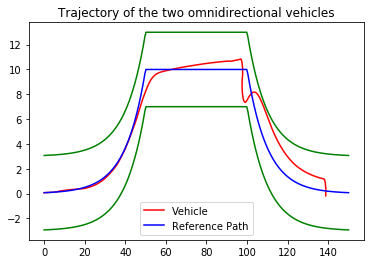

In [137]:
posx = []
posy = []
v = []
theta = []
for i in traj:
    posx.append(i[0][0])
    posy.append(i[0][1])
    v.append(i[0][2])
    theta.append(i[0][3])
    
posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]

_ = plt.title("Trajectory of the two omnidirectional vehicles")
_ = plt.plot(posx, posy, "r")
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend(["Vehicle", "Reference Path"])



The red dots are the steering commands output by the regression model while the blue dots are from the MPC.

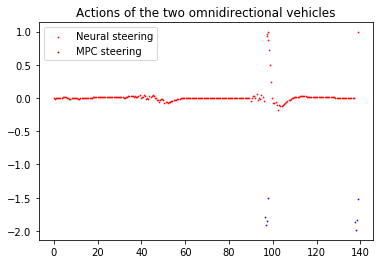

In [135]:

str_nn = []
posx_nn = []
str_mpc = []
posx_mpc = []
for i in nn_traj:
    posx_nn.append(i[0][0])
    str_nn.append(i[1][1])
for j in mpc_traj:
    posx_mpc.append(j[0][0])
    str_mpc.append(j[1][1])
    

_ = plt.title("Actions of the two omnidirectional vehicles")
_ = plt.scatter(posx_nn, str_nn, s = 0.5, c = "r")
_ = plt.scatter(posx_mpc, str_mpc, s = 0.5, c = "b")
_ = plt.legend(["Neural steering", "MPC steering"])

MPSC Guided Learning
=====================

I have considered two algorithms different from what we have discussed. Instead of filtering the learning-based controller's output during deploying phase, MPC can be used as a filter during training phase. The ultimate goal is that the learning model maintains high performance while avoiding performing unsafe behavior.

The basic set up is that the environment has state space $X$, control space $U$ as well as the known, perhaps nonlinear dynamics $x_{k+1} = f(x_k, u_k)$ where $x_k,u_k$ are current state and action pairs and $x_{k+1}$ is next state. Given a learning based controller $g:X\times \Theta\rightarrow U$ where $\Theta$ is the parameter space, a set of trajectories $\{\tau_i|\tau_i=(x^{(i)}_0, u^{(i)}_0, x^{(i)}_1, u^{(i)}_1, \ldots)\}$ can be obtained by executing $g$. Define the convex set of safe states $\{x|x\in X, UNSAFE(x)\leq 0\}$. Assume that an unsafe controller $g$ is at hand. It can generate at least one trajectory $\tau=(x_0, a_0, x_1, a_1, \ldots x_T, a_T\}$ that reaches an unsafe state.

The algorithm is inspired by the motivation of iLQR, which is to linearize the nonlinear dynamics. Given one trajectory $\tau$, a perturbation can be added to this trajectory, i.e. $x_k\rightarrow x_k + \delta x_k, u_k\rightarrow u_k +\delta u_k$. Then the relationship between $\delta x_k,\delta u_k$ can be obtained as follows.

\begin{eqnarray}
x_{k+1} &=& f(x_k, u_k)\\
x_{k+1} \delta x_{k+1} &=& f(x_k+\delta x_k, u_k + \delta u_k) \\
\delta x_{k+1} &=& f(x_k+\delta, u_k + \delta u_k) - f(x_k, u_k)\\
&\approx& \nabla_x f(x_k, u_k) \delta x_k + \nabla_u f(x_k, u_k) \delta u_k
\end{eqnarray}


<h2>MPSC Guided Policy Search</h2>

Usually, learning-based controller upates its model parameter iteratively during the training phase. We can use MPSC to filter the update. It is already known that $u_k=g(x_k, \theta)$.Then the following equation holds.

\begin{eqnarray}
u_k &=& g(x_k, \theta)\\
u_k + \delta u_k &=& g(x_k + \delta x_k, \theta + \delta \theta)\\
\delta u_k &\approx& \nabla_x g(x_k, \theta) \delta x_k + \nabla_\theta g(x_k, \theta) \delta \theta
\end{eqnarray}

Then interpolate it into the linearized dynmics. 
$$\delta x_{k+1} \approx [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x g(x_k, \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta g(x_k, \theta) \delta \theta$$


At this end, we can determine our MPSC problem as, finding the minimal perturbation on the learning model parameters such that the unsafe trajecotries becomes safe.
\begin{eqnarray}
\underset{\delta\theta}{min}&&||\delta \theta||_2^2 \\
s.t. && \delta x_{k+1} = [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x g(x_k, \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta g(x_k, \theta) \delta \theta\qquad k=0, 1, 2, \ldots, T\\
&& \delta x_0 = 0\\
&& UNSAFE(x_k+\delta x_k)\leq 0\qquad k=0, 1, 2, \ldots, T
\end{eqnarray}

In practice, the solved $\delta \theta$ can be applied to the learning model parameter in every iteration. For instance, when using policy gradient to train a parameterized policy $\pi_\theta: X\rightarrow U$, after every gradient step $\theta_{i-1} \rightarrow \theta_{i}$, the resulted policy $\pi_{\theta_i}$ is used to generated samples for the next optimization. Then MPC formulated above can be implemented to the unsafe trajectories (or multiple trajecotries nearby the unsafe set) to further update the policy parameter $\theta_i\rightarrow \theta_i + \delta \theta_i$. 




<h2>MPSC Guided Imitation Learning</h2>


Following the afformentioned basic setup, we can use MPSC in imitation learning, not to perturb the model parameter, but perturb the cost function based on the intermediate sample trajectories. 
It is known that the original IRL formula is 
$$\underset{c}{min}\ \underset{\pi}{max}\ \mathbb{E}_{\pi_E}[c(x, u)] - \mathbb{E}_{\pi} [c(x, u)]$$

It is common in model-free approaches that whenever a new intermediate policy $\pi_{\theta_i}$ is obtained, a set of corresponding sample trajecotries are generated to compare with the expert trajectories $E$ and update the cost function. For instance, in WGAN formulated GAIL, the update of the discriminator $D: X\times U\times W\rightarrow \mathbb{R}$ with parameter space $W$ is as follows.

$$\underset{w\in W}{min}\ \mathbb{E}_{(x,u)\sim \pi_E}[D(x, u, w)] - \mathbb{E}_{(x,u)\sim\pi_{\theta_i}} [D(x, u, w)]$$




Our first step is to find the minimal perturbation to the unsafe intermediate sample trajectories while maintaining high performance. Given an unsafe trajecotry $\tau=(x_0,u_0, \ldots, x_T, u_T)$, the quadratic cost matrices $Q, R$ standard for iLQR are obtained from the current cost $D(, ,w_{i-1})$. Then the MPSC problem is as follows.
\begin{eqnarray}
\underset{\delta x, \delta u}{min} && \delta x^T Q \delta x + \delta u^T R \delta u \\
s.t. && \delta x_{k+1} \approx \nabla_x f(x_k, u_k) \delta x_k + \nabla_u f(x_k, u_k) \delta u_k \qquad k=0, 1, 2, \ldots, T\\
&& \delta x_0 = 0\\
&& UNSAFE(x_k+\delta x_k)\leq 0\qquad k=0, 1, 2, \ldots, T
\end{eqnarray}

Then a constraint can be added to the optimal cost problem such that the perturbed trajecotry $\tau+\delta\tau$ has lower cost than $\tau$. 

\begin{eqnarray}
\underset{w}{min}& &\mathbb{E}_{(x,u)\sim \pi_E}[D(x, u, w)] - \mathbb{E}_{(x,u)\sim\pi_{\theta_i}} [D(x, u, w_{i-1})]\\
s.t. && \sum_{(x_k+\delta x_k,u_k + \delta u_k)\in \tau+\delta_\tau} D(x_k + \delta x_k,u_k + \delta u_k, w) - \sum_{(x_k,u_k)\in \tau} D(x_k,u_k, w)  \leq 0
\end{eqnarray}

However, since $\tau$ is optimal w.r.t the $\pi_{\theta_i}$ which is optimal w.r.t $D(,, w_{i-1})$, the constraint is mostly unlike to be satisfied under $w_{i-1}$. In other word, the constraint of the problem changes in every iteration and the problem can be infeasible in the beginning of every iteration. To simplify the problem, the constraint can be manipulated as follows.

If function $D$ is convex in terms of $x, u$, then subgradient can be used.
\begin{eqnarray}
&&\sum_{(x_k,u_k)\in \tau} D(x_k,u_k, w) - \sum_{(x_k+\delta x_k,u_k + \delta u_k)\in \tau+\delta_\tau} D(x_k+\delta x_k,u_k + \delta u_k, w)  \geq 0\\
&\Rightarrow& \underset{g^{(k)}_i\in \partial_{(x, u)} D(x_k+\delta x_k, u_k + \delta u_k ,w)}{min}\  \sum_{(x_k,u_k)\in\tau} g^{(k)}_i \cdot [-\delta x_k, - \delta u_k]^T\geq 0 
\end{eqnarray}

However, it can be problemetic to find the minimal subgradient in practice. The second proposal does not require convexity to be guaranteed. In every iteration, we can consider two cases. 

If $\sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1}) \geq 0$, which implies that $w_{i-1}$ is feasible, then directly use barrier or penalty method to update $w_{i-1}$. 

If $\sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1}) \leq 0$, then the constraint can be tightened by borrowing the left hand side of the inequality. Assume that a feasible update $\delta w_{i-1}$ on $w_{i-1}$ enables $w_i = w_{i-1} + \delta w_{i-1}$ to satisfy the tightened constraint as below.

\begin{eqnarray}
&&\sum_{\tau+\delta_\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1} + \delta w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1} + \delta w_{i-1})\leq \sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1}) \\
&&\sum_{\tau+\delta_\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1} + \delta w_{i-1}) - \sum_{\tau + \delta\tau} D(x_k,u_k, w_{i-1}) + \sum_{\tau} D(x_k,u_k, w_{i-1})- \sum_{\tau} D(x_k,u_k, w_{i-1} + \delta w_{i-1})  \leq 0\\
&&\nabla_w \sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1})\delta w_{i-1} - \nabla_w \sum_{\tau} D(x_k,u_k, w_{i-1})\delta  w_{i-1}\leq 0\\
&&\nabla_w \sum_{\tau} [D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - D(x_k,u_k, w_{i-1})]\delta w_{i-1}\leq 0
\end{eqnarray}

As a result, the constraint is linearized. The direction of $\delta w_{i-1}$ can be determined by the gradient of the object while the step length is confined by this linear constraint.
